# Urban Traffic Anomaly Detection using Variational Autoencoders (VAE)
#### E. Ruiz de la Cuesta Castaño, M. Invernici, S. Cattonar

In this project, we aim to detect anomalies in urban traffic patterns using a probabilistic machine learning approach based on Variational Autoencoders (VAE). 

We will train the Conditional VAE (CVAE) on typical traffic data so that it learns common patterns. On the learned embeddings we then apply an LSTM to take into account the temporal relation among subsequent timestamps. Eventually, we will detect anomalies as deviations of the reconstructed CVAE-only and CVAE-LSTM timeseries from the original ones.

The dataset used is the METR-LA dataset, which contains traffic speed readings from sensors in Los Angeles collected every 5 minutes.


## Data Description


**METR-LA Dataset**

- Contains traffic speed data from 207 sensors in Los Angeles.
- Data is recorded every 5 minutes, resulting in 12 records per hour.
- The data is stored in an HDF5 file format (`metr-la.h5`), where rows represent timestamps and columns correspond to different sensors.
- Additionally, a precomputed sensor graph adjacency matrix is provided (`adj_mx.pkl`) which encodes the spatial relations between sensors.

The data shape is approximately (34272, 207), meaning 34,272 time steps and 207 sensors.


## Environment Setup

We will use Python 3.8+ and the following key libraries:

- `h5py`: to read `.h5` dataset files  
- `tables` (PyTables): a dependency needed by `pandas` to handle HDF5 files  
- `numpy` and `pandas`: for data manipulation  
- `matplotlib`: for visualization  
- `torch` (PyTorch): to build and train our VAE model  

### Installing required packages

You can install them via pip:

```bash
pip install numpy pandas matplotlib h5py tables torch


## Data Loading and Preprocessing

Firstly, we load the traffic data from the `.h5` file using `h5py`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F

file_path = 'data/metr-la.h5'
df = pd.read_hdf(file_path)
columns_df = df.columns
print(columns_df)
print(df.shape)
print(df.head())
print(df.tail)

Index(['773869', '767541', '767542', '717447', '717446', '717445', '773062',
       '767620', '737529', '717816',
       ...
       '772167', '769372', '774204', '769806', '717590', '717592', '717595',
       '772168', '718141', '769373'],
      dtype='object', length=207)
(34272, 207)
                        773869     767541     767542     717447     717446  \
2012-03-01 00:00:00  64.375000  67.625000  67.125000  61.500000  66.875000   
2012-03-01 00:05:00  62.666667  68.555556  65.444444  62.444444  64.444444   
2012-03-01 00:10:00  64.000000  63.750000  60.000000  59.000000  66.500000   
2012-03-01 00:15:00   0.000000   0.000000   0.000000   0.000000   0.000000   
2012-03-01 00:20:00   0.000000   0.000000   0.000000   0.000000   0.000000   

                        717445  773062  767620     737529     717816  ...  \
2012-03-01 00:00:00  68.750000  65.125  67.125  59.625000  62.750000  ...   
2012-03-01 00:05:00  68.111111  65.000  65.000  57.444444  63.333333  ...   
2012-03-01 00

### Preliminary Investigation

To better understand the nature of the data, we visualize the time series corresponding to five randomly selected sensors on March 2012. These plots provide insight into traffic flow patterns across different locations in Los Angeles.

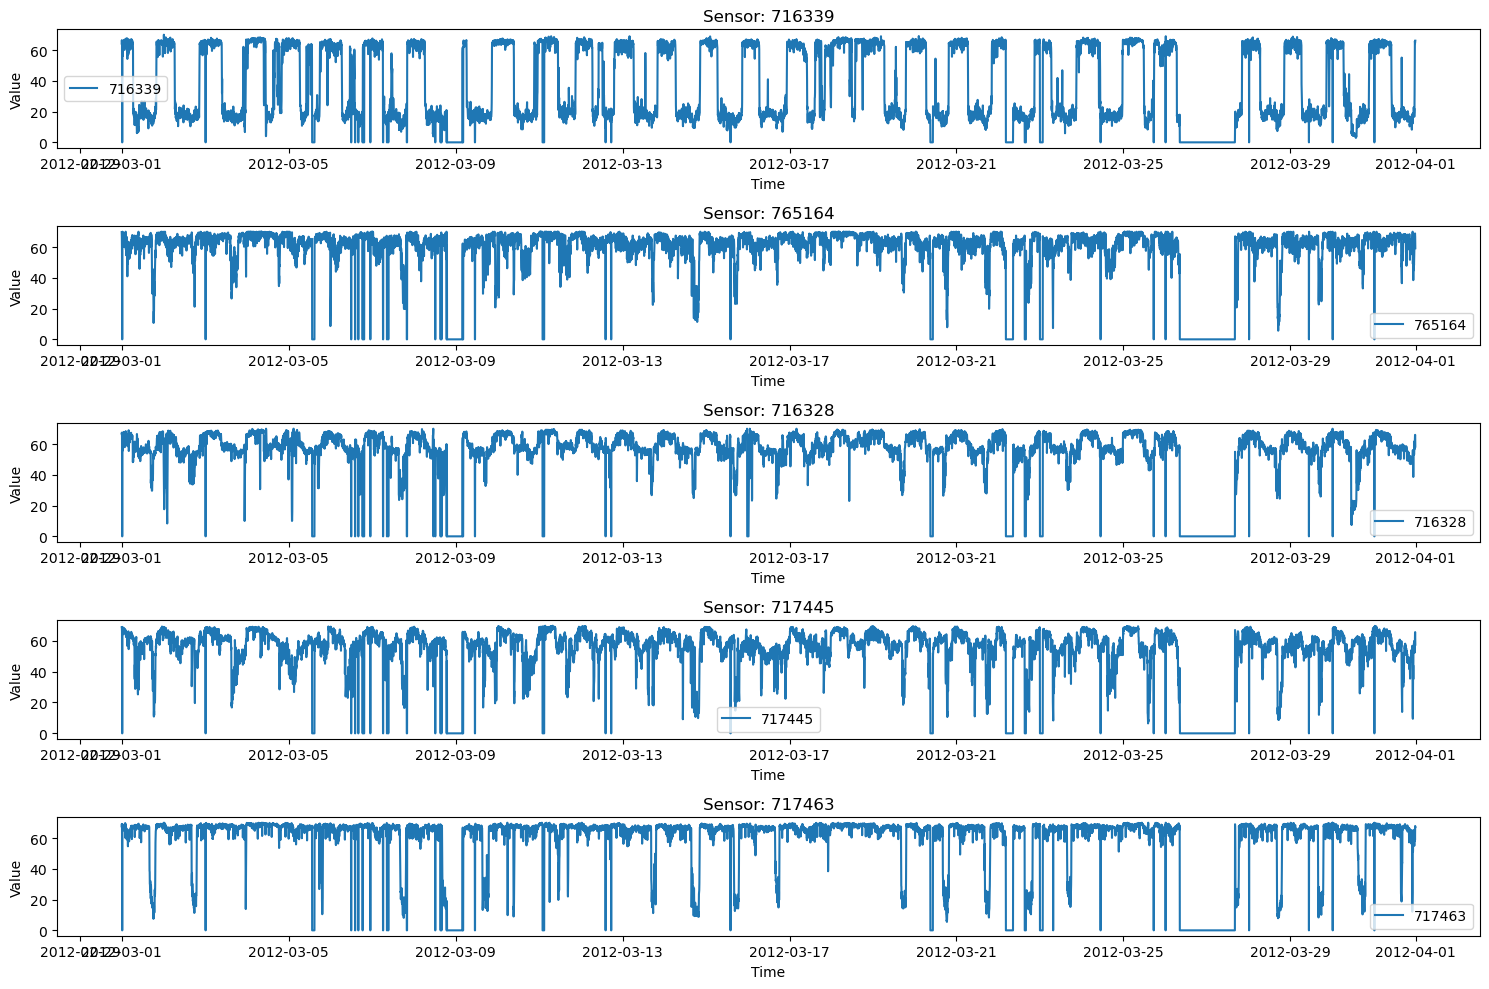

In [2]:

# plotting n plots , one for each time series for randomly picked or specific sensors, just for March 2012
np.random.seed(0)
def plot_random_sensors(df, num_sensors=5, sens=None, start=0, end=len(df)):
    sensors = np.random.choice(df.columns, num_sensors, replace=False)
    if sens is not None:
        # Filter the sensors based on the provided list
        sensors = [s for s in sens if s in df.columns]
    
    df_subset = df[sensors].iloc[start:end]  

    plt.figure(figsize=(15, 10))
    for i, sensor in enumerate(sensors):
        plt.subplot(num_sensors, 1, i + 1)
        plt.plot(df_subset.index, df_subset[sensor], label=sensor)
        plt.title(f'Sensor: {sensor}')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    return sensors

days = 31
hourse_per_day = 24
event_per_hour = 12  # assuming 5 minutes intervals
event_in_march = days * hourse_per_day * event_per_hour - 1 # march 2012: Last event is at 31st March 2012, 23:55

sensors = plot_random_sensors(df, num_sensors=5, end= event_in_march)

From the plots, we observe that certain time intervals contain prolonged sequences of zero values across all sensors. These zero values likely correspond to missing or invalid sensor readings rather than actual traffic conditions. We search information about why this dataset has this "problem" but in the original paper they did not mentioning it. As it is *highly* unlikely that all traffic in Los Angeles would stop simultaneously across several regions, we decided to treat these as anomalies in the dataset.

This observation leads us to investigate more carefully how to handle these anomalies in the preprocessing stage.

Such rows can bias the model, introduce spurious patterns, and negatively affect training performance.
As a solution, we plan to remove these all-zero rows and fill the resulting gaps using synthetic data generated by a generative model.

Before applying this second-stage correction using generative models, we first need to properly prepare the data. This involves four key steps:

1. **Temporal Feature as Conditional Inputs**: Since traffic patterns are highly dependent on time (e.g., rush hours, weekdays vs. weekends), we extract cyclical time features from the timestamps. These features will later serve as **conditional inputs** for our generative model.

2. **Normalization**: The raw traffic speed values vary significantly across sensors. To ensure efficient training and stable convergence, we normalize the data using `StandardScaler`.

3. **Train/Test Splitting**: We split the time series into training and test sets.

4. **Custom Dataset**: We prepare our data in a format compatible with PyTorch's `DataLoader`

### Time Features as Conditional Inputs

Urban traffic patterns are highly dependent on temporal context. For example:
- Traffic usually peaks during rush hours (e.g., 8 AM and 5 PM).
- Weekends typically have different patterns than weekdays.
- There are seasonal effects tied to months or holidays.

To help our model capture these patterns, we extract cyclical time features from the timestamps:
- Hour of day: mapped to sine and cosine to capture the 24-hour periodicity.
- Day of week: similarly encoded to capture weekly cycles.
- We did not extract the month of year because we only have four months in our dataset

Using both sine and cosine components allows the model to learn the cyclical nature of time (e.g., 23:00 and 0:00 are close in time).




                     hour_sin  hour_cos   dow_sin   dow_cos
2012-03-01 00:00:00       0.0       1.0  0.433884 -0.900969
2012-03-01 00:05:00       0.0       1.0  0.433884 -0.900969
2012-03-01 00:10:00       0.0       1.0  0.433884 -0.900969
2012-03-01 00:15:00       0.0       1.0  0.433884 -0.900969
2012-03-01 00:20:00       0.0       1.0  0.433884 -0.900969


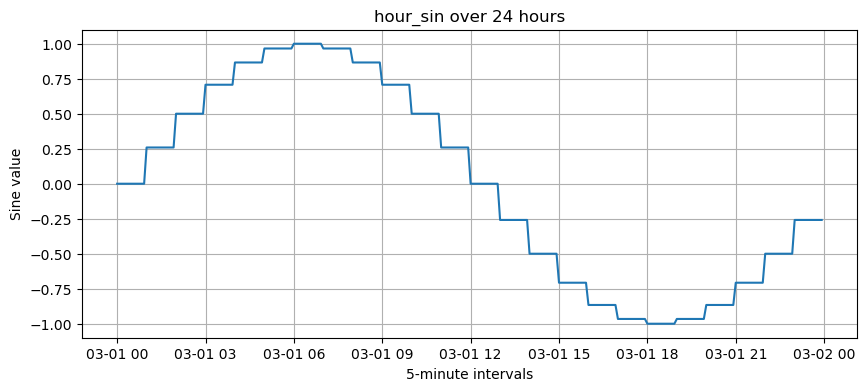

In [3]:
df.index = pd.to_datetime(df.index)
# Create a new DataFrame to store time-based features
df_time = pd.DataFrame(index=df.index)

# Hour of the day (0-23), encoded using sine and cosine to preserve cyclic nature
df_time["hour_sin"] = np.sin(2 * np.pi * df.index.hour / 24)
df_time["hour_cos"] = np.cos(2 * np.pi * df.index.hour / 24)

# Day of the week (0=Monday, 6=Sunday), also cyclic
df_time["dow_sin"] = np.sin(2 * np.pi * df.index.dayofweek / 7)
df_time["dow_cos"] = np.cos(2 * np.pi * df.index.dayofweek / 7)

print(df_time.head())

# Plot one day's worth of hour_sin values (12*24 = 288 samples per day)
plt.figure(figsize=(10, 4))
plt.plot(df_time["hour_sin"][:288])  # 1 día si son datos cada 5 minutos
plt.title("hour_sin over 24 hours")
plt.xlabel("5-minute intervals")
plt.ylabel("Sine value")
plt.grid(True)
plt.show()

### Data Normalization and Splitting

Machine learning models, especially neural networks, tend to perform better when the input features are normalized. Here, we use `StandardScaler` from scikit-learn to apply Z-score normalization to the dataset:

- x: the main dataset with traffic speeds from sensors
- c: the time condition variables we computed earlier (e.g., hour_sin, dow_cos, etc.)

The formula applied is: 
$$
x_{\text{normalized}} = \frac{x - \mu}{\sigma}
$$

Where: 
- 𝜇 is the mean
- 𝜎 is the standard deviation

Each sensor column in x and each time feature in c is scaled independently using this method.

We also split the data into training and test sets to ensure that the scaler is fit only on training data. This assure that the model obtains no info about the future data it will receive, the training output is more realistic.

In [4]:
x = df.values.astype(np.float32)
c = df_time.values.astype(np.float32)

# Split into training and test sets (no shuffling, to preserve temporal order)
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=0.2, shuffle=False)
x_train_original = x_train
x_test_original = x_test
# Standardize the input traffic data (x)
scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train) # Fit on training data
x_test = scaler_x.transform(x_test) # # Transform test data using the same parameters

# Standardize the conditional time features (c)
scaler_c = StandardScaler()
c_train = scaler_c.fit_transform(c_train)
c_test = scaler_c.transform(c_test)

print("Length of x_train:", len(x_train))
print("Length of x_test:",len(x_test))

Length of x_train: 27417
Length of x_test: 6855


### Custom Dataset: `TrafficDataset`

We define a custom `TrafficDataset` to prepare our data in a format compatible with PyTorch's `DataLoader`.

This class:
- Converts the input features (`x`) and conditions (`c`) into tensors.
- Allows easy indexing and batching of the data.
- Returns tuples `(x, c)` so both the data and its condition can be used during model training.

Using a custom dataset class ensures full control over how data is structured and accessed during training and testing.

In [5]:
class TrafficDataset(Dataset):
    def __init__(self, x, c):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.c = torch.tensor(c, dtype=torch.float32)

    def __len__(self):
        # Return the total number of samples
        return self.x.shape[0]

    def __getitem__(self, idx):
        # Retrieve a single sample (x_t, c_t) given an index
        return self.x[idx], self.c[idx]
    
# Create dataset instances for training and test sets
train_dataset = TrafficDataset(x_train, c_train)
print(len(train_dataset))
test_dataset = TrafficDataset(x_test, c_test)

# Create DataLoaders to iterate through data in batches
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
print(len(train_loader))
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

27417
215


Training a Conditional Variational Autoencoder (CVAE) with `shuffle=True` can lead to degraded reconstruction quality on structured time series data. Although the CVAE is theoretically permutation-invariant, in practice, shuffled batches introduce heterogeneity that makes learning the conditional latent distribution $q(z|x, c)$ less stable. This instability affects the sampling step $z \sim \mathcal{N}(\mu, \sigma^2)$, producing reconstructions that are less faithful to the input. With `shuffle=False`, temporally coherent batches allow the model to learn more consistent latent representations, especially when the condition vector $c$ carries limited temporal context. Moreover, heterogeneous batches may cause the KL divergence term to dominate the loss, hurting the reconstruction. Therefore, for structured time-series, training without shuffling can yield better reconstructions even under stochastic decoding.

## Theoretical Background

---

### **Variational Autoencoder (VAE)**

A **Variational Autoencoder** (VAE) is a type of generative model that learns a continuous, probabilistic latent representation of the data. In our case, the VAE will take a window of traffic sensor readings as input, compress it into a low-dimensional latent vector, and then attempt to reconstruct the original readings. By training the VAE on “normal” traffic patterns, it learns which patterns are likely under the data distribution. At inference time, large reconstruction errors can be flagged as anomalies.

#### Main Components:

##### 1. **Encoder**
The encoder network takes an input (e.g., a time window of traffic data) and maps it to a latent distribution. Instead of directly outputting a single latent vector, the encoder outputs:

- A mean vector $\mu$
- A standard deviation (or log variance) vector $\log(\sigma^2)$

These define a multivariate normal distribution from which we sample the latent variable $z$.

##### 2. **Latent Sampling**
To allow backpropagation through the sampling process, VAEs use the **reparameterization trick**:

$$
z = \mu + \sigma \cdot \epsilon \quad \text{where} \quad \epsilon \sim \mathcal{N}(0, I)
$$

This makes the sampling step differentiable.

##### 3. **Decoder**
The decoder takes the sampled latent variable $z$ and tries to reconstruct the original input data. The goal is to learn a meaningful latent space that can generate realistic reconstructions.

#### Loss Function

The VAE loss has two terms that together form the **Evidence Lower Bound (ELBO)**. We optimize (i.e. minimize) the negative ELBO.

1. **Reconstruction Loss** (e.g., Mean Squared Error):

$$
\mathcal{L}_{\text{recon}} = ||x - \hat{x}||^2
$$

This penalizes the model when its reconstruction $\hat{x}$ is far from the original input $x$.

> **Why use MSE as reconstruction loss?**
>
> Theoretically, we want to maximize the log-likelihood of the reconstruction, i.e., $\log p(x|z)$. If we assume that the decoder’s output is Gaussian with fixed variance (i.e., $p(x|z) = \mathcal{N}(\hat{x}, \sigma^2 I)$), then:
>
> $$
> \log p(x|z) = -\frac{1}{2\sigma^2} ||x - \hat{x}||^2 + \text{const}
> $$
>
> So minimizing the squared error (MSE) is equivalent to maximizing the likelihood. That’s why MSE acts as a **proxy** for the negative log-likelihood in practice.


2. **Kullback-Leibler (KL) Divergence**:

$$
\mathcal{L}_{\text{KL}} = D_{\text{KL}}(q(z|x) || p(z))
$$

This measures how much the learned latent distribution $q(z|x)$ (given by the encoder) deviates from the standard normal prior $p(z) = \mathcal{N}(0, I)$.

> **In practice**, the encoder outputs $\mu$ and $\log(\sigma^2)$, and the KL divergence between the approximate posterior and the prior can be computed in closed form:
>
> $$
> \mathcal{L}_{\text{KL}} = -\frac{1}{2} \sum \left(1 + \log(\sigma^2) - \mu^2 - \sigma^2\right)
> $$
>
> This encourages the model to keep the latent representations close to a standard normal distribution.


#### Total Loss

The total loss combines both terms:

$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{recon}} + \beta \cdot \mathcal{L}_{\text{KL}}
$$

where $\beta$ is a hyperparameter (commonly set to 1) that balances reconstruction accuracy and regularization. 

> **Important:** In theory, we want to **maximize** the Evidence Lower Bound (ELBO), which is:
>
> $$
> \text{ELBO}(x) = \mathbb{E}_{q(z|x)}[\log p(x|z)] - D_{\text{KL}}(q(z|x) || p(z))
> $$
>
> But in practice, optimization libraries **minimize** functions. So minimizing the total loss is equivalent to **maximizing the ELBO**.

<br>

---

<br>

### **Static Conditional Variational Autoencoder (CVAE)**

A **Conditional VAE (CVAE)** extends the VAE framework by conditioning both the encoder and decoder on extra context `c`. In our traffic anomaly project, `c` represents **time‐related features** (e.g., `hour_sin`, `hour_cos`, `dow_sin`, etc.). By injecting these features, the model can learn how normal traffic patterns change depending on the time of day, day of week, or month.

> **Why “static” CVAE?**  
> We call it “static” because each training example $(x_t, c_t)$ is treated as independent; we do **not** explicitly model temporal sequences (no RNNs or temporal convolutions). The CVAE simply learns a mapping :
>
>$$
>(x_t, c_t) \;\;\longrightarrow\;\; z \;\;\longrightarrow\;\; (\,\hat{x}_t \mid z, c_t).
>$$
>
> Each pair $(x_t, c_t)$ is processed independently, ignoring direct time‐series dependencies beyond what is encoded in $c_t$.

#### Main Components

- **Input (`x`)**: The data to be reconstructed (e.g., sensor readings).
- **Condition (`c`)**: Extra information that provides context (e.g., timestamp, holiday flag).
- **Encoder**: Maps `x` and `c` into a latent distribution `z ~ q(z|x, c)`.
- **Latent space (`z`)**: A compressed, learned representation of the input data.
- **Decoder**: Uses `z` and `c` to reconstruct the input: `x̂ = p(x|z, c)`.

<br>

---

<br>

### **CVAE + Long Short Term Memory (LSTM) reconstruction in latent space**

A **LSTM** (Long Short-Term Memory) is a type of recurrent neural network designed to model sequences and capture long-term dependencies through gated mechanisms that control information flow over time.

The **CVAE + LSTM** model extends the CVAE by introducing an LSTM that operates in the latent space. The CVAE encodes each timestep of a traffic speed sequence into an embedding; the LSTM then models the temporal evolution of these embeddings, predicting the last window_size-1 embeddings using the first window_size -1 ones. Only the **last predicted embedding** is decoded, summarizing the full sequence for reconstruction.

**Trainings** of CVAE and LSTM are kept separate: this improves stability and modularity:
* **Decoupled objectives**: The CVAE learns to encode/reconstruct, while the LSTM models temporal dynamics. Joint training can lead to conflicting gradients and unstable convergence.
* **Better control**: The encoder can be validated independently for embedding quality before feeding sequences to the LSTM.
* **Modularity**: Once trained, components can be reused or replaced independently (e.g., testing different sequence models on the same embeddings).
* **Simpler debugging**: Isolating errors or performance issues is easier when training in stages.

<br>

> **Why use LSTM inside a CVAE for anomaly detection on traffic speed data?**
> VAE works out for indipendent input data, while time series are characterized by innate sequential dependencies. The inception of a LSTM modul inside the original CVAE allows to account for these dependencies.


#### Main Components

* **Encoder (`x`)**: Maps each timestep of input to a latent embedding.
* **Condition (`c`)**: Provides context (e.g., time, day type) to guide encoding and decoding.
* **LSTM**: Models the sequence of embeddings and predicts the next (last) embedding.
* **Decoder**: Reconstructs the final output from the last predicted embedding.

<br>

---

<br>

### **In the next sections**

We start with the trainining of our CVAE on the preprocessed original dataset. Soon after, we apply it to inpute the missing values in the train dataset where rows have all zeros and we retrain the model on the 'cleaned' train dataset. 

We evalutate the model over the test set and ouput the reconstructed data. 

To conclude the section of CVAE-only model we visualize the results: we plot the reconstructed data over the original ones in four plots of different timestamps (specific moments in time).

Subsequently, we extend the CVAE framework by feeding its learned latent embeddings into an LSTM network to capture temporal dependencies.

Firstly, we present the LSTM model definition, the preprocessing of LSTM input data (CVAE embeddings obtained from the cleaned training dataset) and LSTM training. 

Secondly, we present the CVAE_LSTM model evaluation over the test dataset.

Finally, as for the CVAE we visualize the results.
<br>

---

## CVAE model and Training Strategy

To address the issue of missing or anomalous data and to prepare the model for detecting anomalies, we adopt a **two-phase training strategy** using the same Conditional Variational Autoencoder (CVAE) architecture.

*   **1. Static CVAE Training on raw data (with zero rows)**

In the first phase, we train the CVAE on individual time steps from the original dataset, **without removing rows with zero values**. Each input sample is a vector representing sensor readings at a single timestamp, and time features (such as hour of day and day of week) are used as conditional inputs.

The goal of this phase is to learn the general distribution of traffic sensor readings. Once trained, the model is used to **generate plausible synthetic samples to fill in the rows where all sensor values are zero**, using the corresponding time features for conditioning.

This step allows us to repair the dataset by replacing structurally invalid inputs with statistically consistent samples, improving the overall quality of the data before detecting anomalies.

*   **2. CVAE Retraining on clean data (with reconstucted zero rows)**

After filling the missing data, we retrain the same CVAE model on the clean dataset for letting the model learn a normal pattern.

In [6]:
# Static Conditional VAE
class CVAE(nn.Module):
    def __init__(self, input_dim, cond_dim, latent_dim=16):
        """
        input_dim  : dimensionality of the input vector x (e.g., number of sensors)
        cond_dim   : dimensionality of the condition vector c (e.g., number of time features)
        latent_dim : size of the latent space (z)
        """
        super(CVAE, self).__init__()

        # We will concatenate x and c into a single vector of size (input_dim + cond_dim).
        # Then we pass through two hidden layers: 128 -> 64.
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + cond_dim, 128), # First dense layer
            nn.ReLU(),                            # Non-linearity
            nn.Linear(128, 64),                   # Second dense layer
            nn.ReLU()
        )

        # After the two layers, we map the 64-dimensional hidden state to:
        #   1) mu (mean) of size latent_dim
        #   2) logvar (log variance) of size latent_dim
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

        # The decoder takes a latent sample z (size latent_dim) concatenated with the condition c (size cond_dim),
        # forming a vector of size (latent_dim + cond_dim). Then we map:
        #   latent_dim + cond_dim -> 64 -> 128 -> input_dim
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim) # Output is same size as original x
        )

    def encode(self, x, c):
        h = self.encoder(torch.cat([x, c], dim=1))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        return self.decoder(torch.cat([z, c], dim=1))

    def forward(self, x, c):
        """
        Full forward pass:
        1) Encode (x, c) to obtain mu and logvar.
        2) Sample z using the reparameterization trick.
        3) Decode (z, c) to get reconstructed x.
        Returns:
            x_recon : reconstructed input
            mu      : mean of latent distribution
            logvar  : log-variance of latent distribution
        """
        # 1) Encode input + condition → (mu, logvar)
        mu, logvar = self.encode(x, c)
        # 2) Sample z using reparameterization
        z = self.reparametrize(mu, logvar)
        # 3) Decode the sampled z (with c) → reconstruction
        x_recon = self.decode(z, c)
        return x_recon, mu, logvar

In [7]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_loss = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    return recon_loss + kl_loss, recon_loss, kl_loss

### 1. Static CVAE Training on raw data (with zero rows)

In [8]:
import torch.optim as optim

device = torch.device("cpu")

# Input dimensions from the training data:
input_dim = x_train.shape[1]
cond_dim = c_train.shape[1]

latent_dim = 16
 
static_vae_model = CVAE(input_dim, cond_dim, latent_dim).to(device)

# Create an Adam optimizer to update all model parameters
optimizer = optim.Adam(static_vae_model.parameters(), lr=1e-3)

num_epochs = 50

# --- Training Loop ---
for epoch in range(num_epochs):
    static_vae_model.train()
    total_loss, total_recon, total_kl = 0, 0, 0

    # Iterate over the training data in mini-batches provided by train_loader
    for x_batch, c_batch in train_loader:
        x_batch, c_batch = x_batch.to(device), c_batch.to(device)

        # Zero out all accumulated gradients before computing new ones
        optimizer.zero_grad()

        # Forward pass: compute the reconstruction, plus mu and logvar from the encoder
        x_recon, mu, logvar = static_vae_model(x_batch, c_batch)

        # CVAE loss:
        loss, recon_loss, kl_loss = loss_function(x_recon, x_batch, mu, logvar)
        
        # Backward pass: compute gradients of loss w.r.t. model parameters
        loss.backward()

        # Update model parameters using the computed gradients
        optimizer.step()

        # Accumulate the summed losses across all examples in this batch
        total_loss += loss.item() * x_batch.size(0)
        total_recon += recon_loss.item() * x_batch.size(0)
        total_kl += kl_loss.item() * x_batch.size(0)
    
    # After finishing all batches in this epoch, compute the average loss per example
    dataset_size = len(train_loader.dataset)
    avg_loss  = total_loss  / dataset_size
    avg_recon = total_recon / dataset_size
    avg_kl    = total_kl    / dataset_size

    # Print out the epoch summary: average total loss, reconstruction loss, and KL loss
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Loss: {avg_loss:.4f} | "
          f"Recon: {avg_recon:.4f} | "
          f"KL: {avg_kl:.4f}")

Epoch 1/50 - Loss: 1.0030 | Recon: 0.9918 | KL: 0.0112
Epoch 2/50 - Loss: 0.9418 | Recon: 0.9403 | KL: 0.0015
Epoch 3/50 - Loss: 0.9192 | Recon: 0.9186 | KL: 0.0006
Epoch 4/50 - Loss: 0.9053 | Recon: 0.9049 | KL: 0.0004
Epoch 5/50 - Loss: 0.8930 | Recon: 0.8927 | KL: 0.0003
Epoch 6/50 - Loss: 0.8840 | Recon: 0.8838 | KL: 0.0002
Epoch 7/50 - Loss: 0.8761 | Recon: 0.8760 | KL: 0.0002
Epoch 8/50 - Loss: 0.8705 | Recon: 0.8704 | KL: 0.0001
Epoch 9/50 - Loss: 0.8665 | Recon: 0.8664 | KL: 0.0001
Epoch 10/50 - Loss: 0.8629 | Recon: 0.8628 | KL: 0.0001
Epoch 11/50 - Loss: 0.8598 | Recon: 0.8597 | KL: 0.0001
Epoch 12/50 - Loss: 0.8598 | Recon: 0.8597 | KL: 0.0001
Epoch 13/50 - Loss: 0.8571 | Recon: 0.8570 | KL: 0.0001
Epoch 14/50 - Loss: 0.8541 | Recon: 0.8540 | KL: 0.0001
Epoch 15/50 - Loss: 0.8530 | Recon: 0.8529 | KL: 0.0001
Epoch 16/50 - Loss: 0.8511 | Recon: 0.8511 | KL: 0.0001
Epoch 17/50 - Loss: 0.8504 | Recon: 0.8503 | KL: 0.0001
Epoch 18/50 - Loss: 0.8487 | Recon: 0.8486 | KL: 0.0001
E

Reconstruction of the velocities for the train set using the static CVAE model:

In [9]:
reconstructed_train = []
originals_train = []
reconstructed_test = []
originals_test = []

static_vae_model.eval()
with torch.no_grad():
    for x_batch, c_batch in train_loader:
        x_batch, c_batch = x_batch.to(device), c_batch.to(device)
        x_recon, _, _ = static_vae_model(x_batch, c_batch)
        reconstructed_train.append(x_recon.cpu())
        originals_train.append(x_batch.cpu())

x_train_recon = torch.cat(reconstructed_train, dim=0)  
print(x_train_recon.shape)

torch.Size([27417, 207])


Cleaning the training dataset from all zeroes rows:

In [10]:
mask_zero_rows = (x_train_original.sum(axis=1) == 0)
print(mask_zero_rows.sum())
train_timestamps = df.index[:len(x_train_original)]

# Converting to a pandas dataframe 
x_train_cleaned_df = pd.DataFrame(data=x_train, index=train_timestamps, columns=columns_df) # with zero values
x_train_recon_df = pd.DataFrame(data=x_train_recon, index=train_timestamps, columns=columns_df) # reconstructed values

x_train_cleaned_df.loc[mask_zero_rows] = x_train_recon_df.loc[mask_zero_rows]
print(mask_zero_rows.shape)
print(x_train.shape)
print(x_train_recon_df.shape)
print(x_train_cleaned_df)

1482
(27417,)
(27417, 207)
(27417, 207)
                       773869    767541    767542    717447    717446  \
2012-03-01 00:00:00  0.429949  0.442313  0.334774  0.751146  1.061140   
2012-03-01 00:05:00  0.354863  0.504537  0.238420  0.813308  0.930317   
2012-03-01 00:10:00  0.413466  0.183202 -0.073736  0.586599  1.040956   
2012-03-01 00:15:00  0.137173  0.076236  0.113263  0.434257  0.722361   
2012-03-01 00:20:00  0.151273  0.085779  0.121192  0.459922  0.760294   
...                       ...       ...       ...       ...       ...   
2012-06-04 04:20:00  0.528842 -0.184569  0.169937  0.364461  0.892939   
2012-06-04 04:25:00  0.393932  0.185060  0.359460  0.345264  1.055907   
2012-06-04 04:30:00  0.353032 -0.284870  0.205771  0.537235  0.960219   
2012-06-04 04:35:00  0.495877 -0.109343  0.406442  0.438507  0.913123   
2012-06-04 04:40:00  0.393932  0.014176  0.384942  0.637791  0.900414   

                       717445    773062    767620    737529    717816  ...  \
2012-

Now we can see if we still have those zero-speed peaks on specific dates:

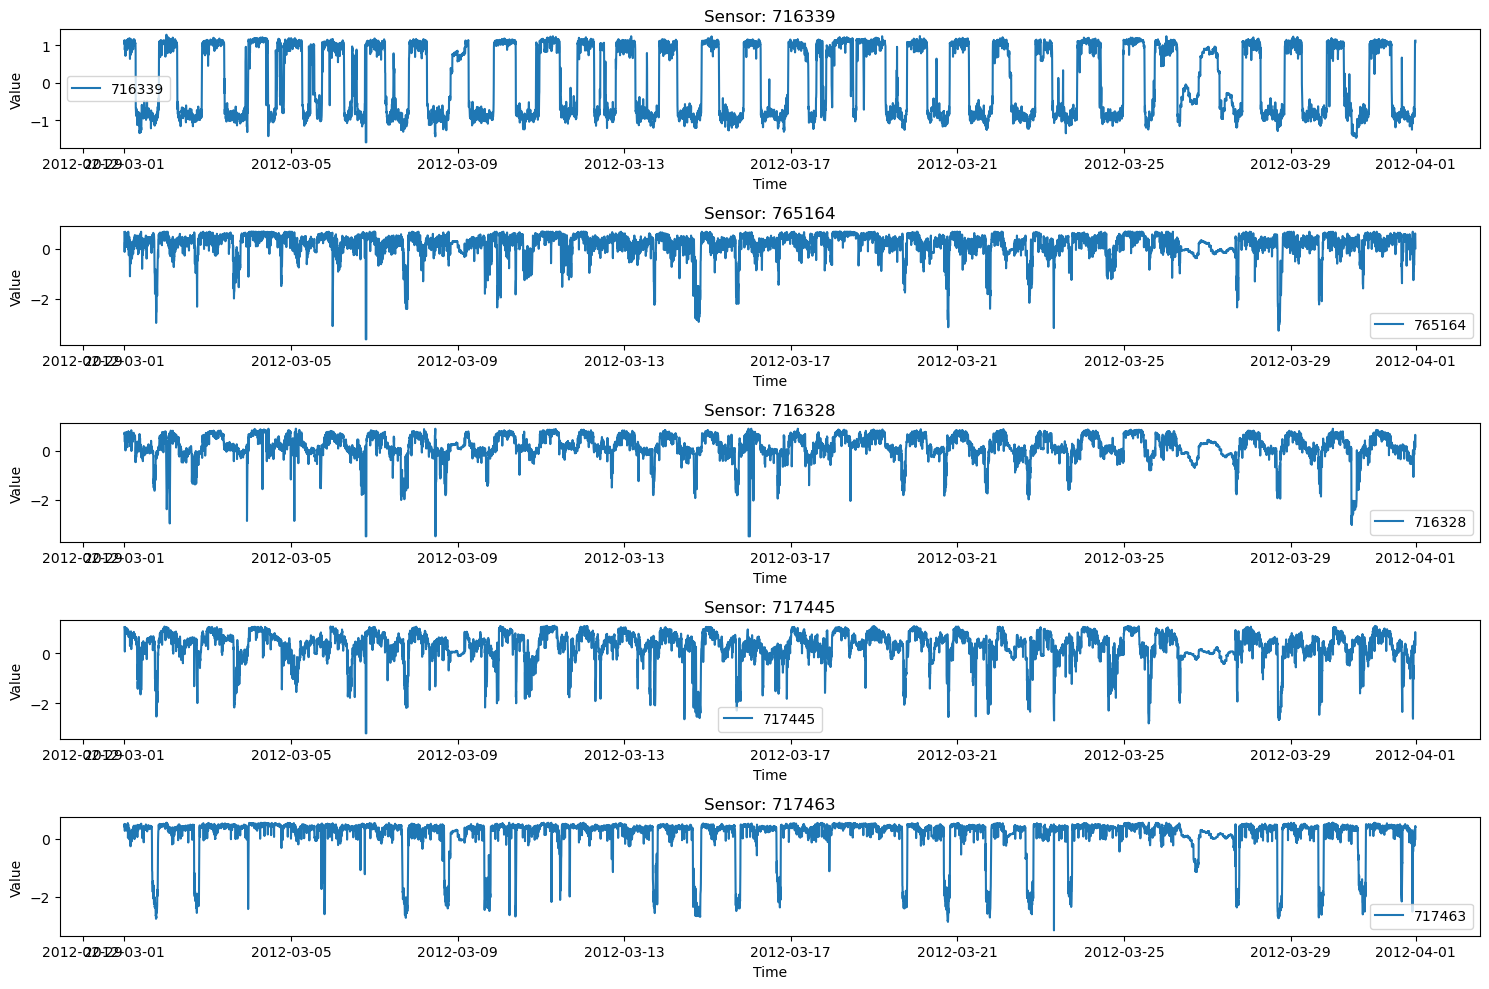

In [11]:
sensors_list = ['716339', '765164', '716328', '717445', '717463']
sensors = plot_random_sensors(x_train_cleaned_df, num_sensors=5, sens = sensors_list, end=event_in_march)

As we can see, the dataset is really better.

In [12]:
# Create dataset instances for training 
x_train_numpy = x_train_cleaned_df.to_numpy()
train_dataset_cleaned = TrafficDataset(x_train_numpy, c_train)


# Create DataLoaders to iterate through data in batches
train_loader_cleaned = DataLoader(train_dataset_cleaned, batch_size=128, shuffle=False)

### 2. CVAE Retraining on clean data (with reconstucted zero rows)

In [13]:
device = torch.device("cpu")

# Input dimensions from the training data:
input_dim = x_train.shape[1]
cond_dim = c_train.shape[1]

latent_dim = 16
 
second_vae = CVAE(input_dim, cond_dim, latent_dim).to(device)

# Create an Adam optimizer to update all model parameters
optimizer = optim.Adam(second_vae.parameters(), lr=1e-3)

num_epochs = 50

# --- Training Loop ---
for epoch in range(num_epochs):
    second_vae.train()
    total_loss, total_recon, total_kl = 0, 0, 0

    # Iterate over the training data in mini-batches provided by train_loader
    for x_batch, c_batch in train_loader_cleaned:
        x_batch, c_batch = x_batch.to(device), c_batch.to(device)

        # Zero out all accumulated gradients before computing new ones
        optimizer.zero_grad()

        # Forward pass: compute the reconstruction, plus mu and logvar from the encoder
        x_recon, mu, logvar = second_vae(x_batch, c_batch)

        # CVAE loss:
        loss, recon_loss, kl_loss = loss_function(x_recon, x_batch, mu, logvar)
        
        # Backward pass: compute gradients of loss w.r.t. model parameters
        loss.backward()

        # Update model parameters using the computed gradients
        optimizer.step()

        # Accumulate the summed losses across all examples in this batch
        total_loss += loss.item() * x_batch.size(0)
        total_recon += recon_loss.item() * x_batch.size(0)
        total_kl += kl_loss.item() * x_batch.size(0)
    
    # After finishing all batches in this epoch, compute the average loss per example
    dataset_size = len(train_loader.dataset)
    avg_loss  = total_loss  / dataset_size
    avg_recon = total_recon / dataset_size
    avg_kl    = total_kl    / dataset_size

    # Print out the epoch summary: average total loss, reconstruction loss, and KL loss
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Loss: {avg_loss:.4f} | "
          f"Recon: {avg_recon:.4f} | "
          f"KL: {avg_kl:.4f}")

Epoch 1/50 - Loss: 0.4357 | Recon: 0.4281 | KL: 0.0076
Epoch 2/50 - Loss: 0.3683 | Recon: 0.3675 | KL: 0.0009
Epoch 3/50 - Loss: 0.3393 | Recon: 0.3389 | KL: 0.0005
Epoch 4/50 - Loss: 0.3215 | Recon: 0.3213 | KL: 0.0002
Epoch 5/50 - Loss: 0.3125 | Recon: 0.3124 | KL: 0.0001
Epoch 6/50 - Loss: 0.3073 | Recon: 0.3072 | KL: 0.0001
Epoch 7/50 - Loss: 0.3039 | Recon: 0.3039 | KL: 0.0000
Epoch 8/50 - Loss: 0.3013 | Recon: 0.3013 | KL: 0.0000
Epoch 9/50 - Loss: 0.2993 | Recon: 0.2992 | KL: 0.0000
Epoch 10/50 - Loss: 0.2980 | Recon: 0.2980 | KL: 0.0000
Epoch 11/50 - Loss: 0.2964 | Recon: 0.2963 | KL: 0.0000
Epoch 12/50 - Loss: 0.2954 | Recon: 0.2954 | KL: 0.0000
Epoch 13/50 - Loss: 0.2943 | Recon: 0.2943 | KL: 0.0000
Epoch 14/50 - Loss: 0.2933 | Recon: 0.2933 | KL: 0.0000
Epoch 15/50 - Loss: 0.2924 | Recon: 0.2924 | KL: 0.0000
Epoch 16/50 - Loss: 0.2916 | Recon: 0.2916 | KL: 0.0000
Epoch 17/50 - Loss: 0.2910 | Recon: 0.2910 | KL: 0.0000
Epoch 18/50 - Loss: 0.2903 | Recon: 0.2903 | KL: 0.0000
E

Now we want to evaluate the second model, to do that we must reconstruct all the test set:

In [14]:
reconstructed = []
originals = []

second_vae.eval()
with torch.no_grad():
    for x_batch, c_batch in test_loader:
        x_batch, c_batch = x_batch.to(device), c_batch.to(device)
        x_recon, _, _ = static_vae_model(x_batch, c_batch)
        reconstructed.append(x_recon.cpu())
        originals.append(x_batch.cpu())

x_test_full_recon = torch.cat(reconstructed, dim=0)
x_orig_all = torch.cat(originals, dim=0)
print(x_test_full_recon.shape)
print(x_orig_all.shape)

torch.Size([6855, 207])
torch.Size([6855, 207])


## Visualization of CVAE Results

### 1. Reconstruction of Speeds for Different Samples

These plots compare the **real** sensor speeds against the **reconstructed** speeds generated by the CVAE model for different timestamps.

- **Purpose:**  
  To visually assess how well the model reproduces the original traffic speed pattern for these particular samples.

- **What to look for:**  
  - If the two lines closely overlap, the model accurately reconstructs the traffic speeds.  
  - Large deviations indicate the model struggles to capture some sensor readings correctly.


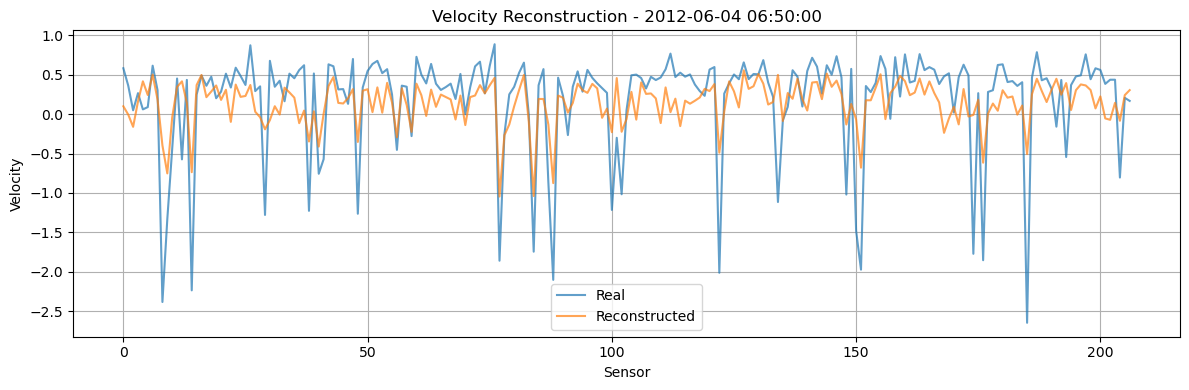

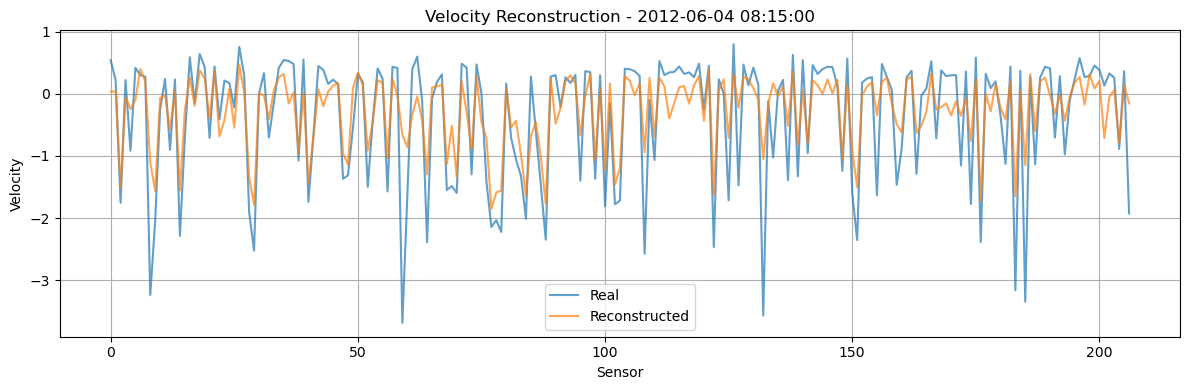

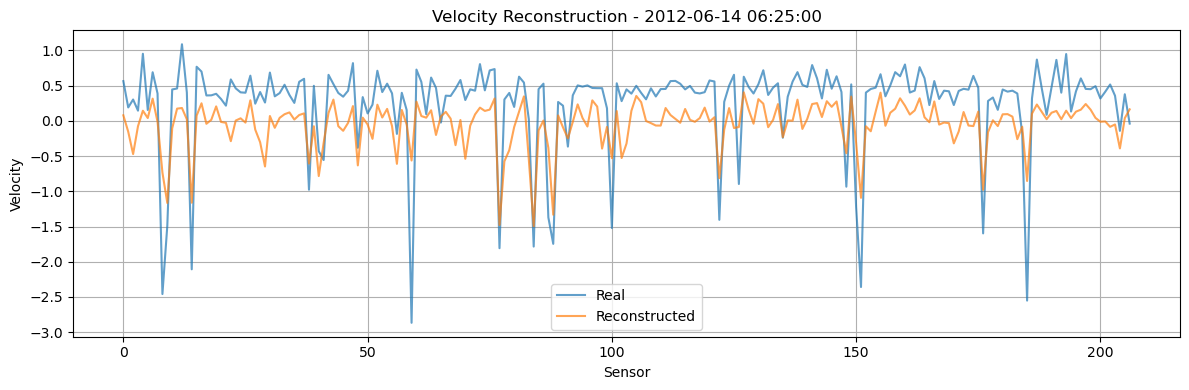

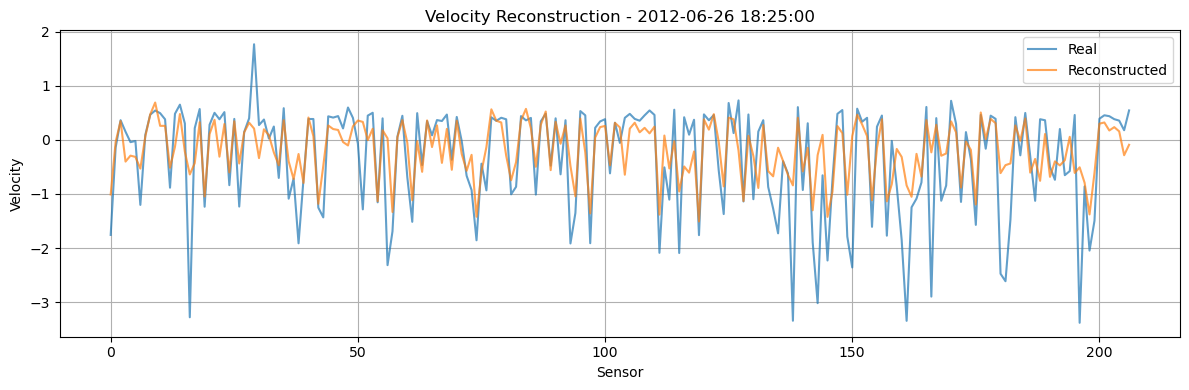

In [15]:
# Plot original vs reconstructed velocities for the selected sample

test_timestamp = df.index[-len(x_test_original):]

# Select a sample index to visualize
sample_indices = [25, 42, 2900, 6500]

for idx in sample_indices:
    timestamp_str = test_timestamp[idx]
    plt.figure(figsize=(12, 4))
    plt.plot(x_orig_all[idx], label="Real", alpha=0.7)
    plt.plot(x_test_full_recon[idx], label="Reconstructed", alpha=0.7)
    plt.title(f"Velocity Reconstruction - {timestamp_str}")
    plt.xlabel("Sensor")
    plt.ylabel("Velocity")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### 2. Analysis and visualization of anomalies per sample and timestamp 

To understand if the selected model is usefull to detect anomalies we can now calculate the MSE per sensor and per timestamp.

We use the score function to compute the MSE between reconstruction and real data for each sensor. This allows us to identify anomalous sensors when the error exceeds a percentile threshold. In the future, it would be interesting to explore a composite score that considers both the magnitude of the anomaly and the number of anomalous sensors, for a more robust detection.

>$$
\text{Score}_{t \in W,s} = \sum_{t} \left(x^{\text{recon}}_{t,s} - x^{\text{orig}}_{t,s} \right)^2
$$

In [16]:
import matplotlib.dates as mdates
# Compute MSE for each sample and sensor (shape: [num_samples, num_sensors])
mse_matrix = (x_orig_all - x_test_full_recon) ** 2 
print(mse_matrix.shape)

# Option 2: Use percentile threshold (e.g., 99.5th percentile)
percentile = 0.995
thresholds = torch.quantile(mse_matrix, percentile, dim=0)


# Detect anomalies: boolean matrix where True means anomaly for that sensor in that sample
anomalies = mse_matrix > thresholds
print(f"Anomalies detected: {anomalies.sum().sum()}")

# Count how many sensors are anomalous in each sample
anomalous_counts = anomalies.sum(dim=1) 

print("Start of test set:", df.index[-len(x_test)])
print("End of test set:", df.index[-1])
test_timestamps = df.index[-len(x_test):]

torch.Size([6855, 207])
Anomalies detected: 7245
Start of test set: 2012-06-04 04:45:00
End of test set: 2012-06-27 23:55:00


In [17]:
import torch

# Get indices of top 10 samples with most anomalies
top_indices = torch.topk(anomalous_counts, 10).indices
top_values = torch.topk(anomalous_counts, 10).values
print(top_values)

print("Top timestamps with the most anomalies:")
for idx in top_indices:
    ts = test_timestamps[idx.item()] # get timestamp for the sample
    count = anomalous_counts[idx].item() # get number of anomalous sensors in that sample
    print(f"Index: {idx.item()} → Date: {ts} → Anomalous Sensors: {count}")


tensor([132, 126, 125, 122, 119, 118, 116, 111, 111, 108])
Top timestamps with the most anomalies:
Index: 1486 → Date: 2012-06-09 08:35:00 → Anomalous Sensors: 132
Index: 3483 → Date: 2012-06-16 07:00:00 → Anomalous Sensors: 126
Index: 3662 → Date: 2012-06-16 21:55:00 → Anomalous Sensors: 125
Index: 3657 → Date: 2012-06-16 21:30:00 → Anomalous Sensors: 122
Index: 3661 → Date: 2012-06-16 21:50:00 → Anomalous Sensors: 119
Index: 3658 → Date: 2012-06-16 21:35:00 → Anomalous Sensors: 118
Index: 3660 → Date: 2012-06-16 21:45:00 → Anomalous Sensors: 116
Index: 1485 → Date: 2012-06-09 08:30:00 → Anomalous Sensors: 111
Index: 3488 → Date: 2012-06-16 07:25:00 → Anomalous Sensors: 111
Index: 1468 → Date: 2012-06-09 07:05:00 → Anomalous Sensors: 108


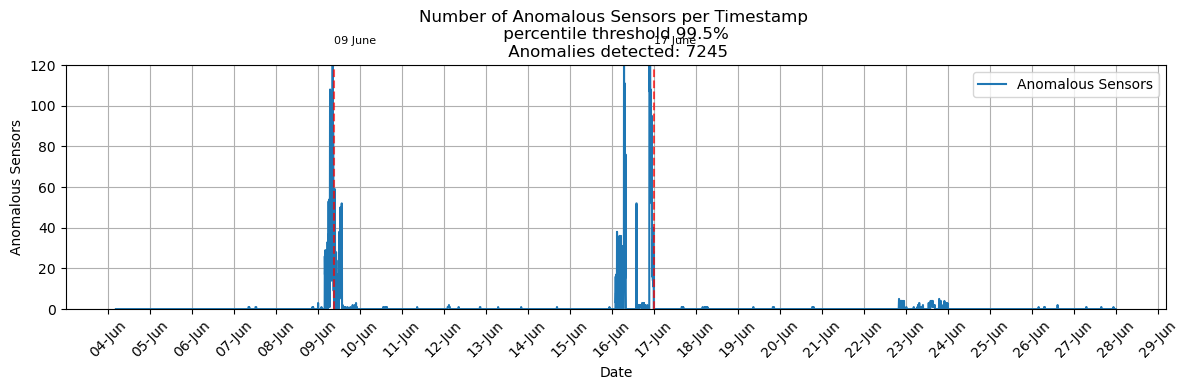

In [18]:
fig, ax = plt.subplots(figsize=(12, 4))

# Plot number of anomalous sensors over time (timestamps)
ax.plot(test_timestamps, anomalous_counts, label='Anomalous Sensors')

# Format X axis to show dates nicely
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

# Define some important event dates to mark on the plot
event_dates = {
    '17 June': pd.to_datetime('2012-06-17 00:00:00'),
    '09 June': pd.to_datetime('2012-06-09 09:10:00'),
    #'Unexplained Anomaly': pd.to_datetime('2012-06-07 07:35:00')
}

for label, date in event_dates.items():
    ax.axvline(date, color='red', linestyle='--', alpha=0.7)
    ax.text(date, max(anomalous_counts), label,
            rotation=0, verticalalignment='center', fontsize=8)

plt.title(f"Number of Anomalous Sensors per Timestamp \n percentile threshold {percentile*100}% \n Anomalies detected: {anomalies.sum().sum()}")
plt.xlabel("Date")
plt.ylabel("Anomalous Sensors")
ax.set_ylim(0,120)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


This plot displays the number of sensors detected as anomalous for each timestamp in the test dataset. The x-axis shows the dates, and the y-axis indicates how many sensors were flagged as anomalies at each point in time.

Red dashed vertical lines mark were we have a lot of all zeros lines in June. 

It is evident that at least the model is able to highlight the biggest system anomalies. 

## LSTM model

### 1. LSTM model definition

In [19]:
# --- LSTM ---
class LSTM_Predictor(nn.Module):
    """
    LSTM-based predictor for sequences of latent embeddings.

    Args:
        embedding_dim (int): Dimensionality of each embedding in the sequence.
        hidden_dim (int): Number of hidden units in the LSTM.
        num_layers (int): Number of stacked LSTM layers.
        dropout_prob (float): Dropout probability (applied if num_layers > 1). For regularization.

    Methods:
        forward(x): Returns predicted embedding sequence.
        compute_loss(predicted_sequence, target_last_embedding): Computes MSE loss on last predicted embedding.
    """
    def __init__(self, embedding_dim, hidden_dim, num_layers=1, dropout_prob=0.1):
        super(LSTM_Predictor, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM processes input sequences of embeddings
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True, # input output LSTM: (batch, seq, feature).
            dropout=dropout_prob if num_layers > 1 else 0
        )
        # Linear layer maps LSTM outputs back to embedding space
        self.fc = nn.Linear(hidden_dim, embedding_dim)

        # MSE loss for comparing predicted and true embeddings
        #self.criterion = nn.MSELoss() #draft3 +

    def forward(self, x):
        """
        Forward pass through LSTM and linear layer.

        Args:
            x (Tensor): Input of shape (batch_size, seq_len, embedding_dim)

        Returns:
            predictions (Tensor): Predicted embeddings, shape (batch_size, seq_len, embedding_dim)
        """
        lstm_out, _ = self.lstm(x) # LSTM output: (batch, seq_len, hidden_dim)
        predictions = self.fc(lstm_out) # Map to embedding_dim
        return predictions
    
    # loss : draft3 +
    def compute_loss(self, predicted_sequence, target_last_embedding):
        """
        Compute MSE loss between the last predicted embedding and the true last embedding.

        Args:
            predicted_sequence (Tensor): Output from forward(), shape (batch_size, seq_len, embedding_dim)
            target_last_embedding (Tensor): True last embedding, shape (batch_size, embedding_dim)

        Returns:
            loss (Tensor): Scalar MSE loss
        """

        predicted_last = predicted_sequence[:, -1, :] #Last time step prediction
        #
        criterion = torch.nn.MSELoss(reduction='mean')
        debug_loss = criterion(predicted_last, target_last_embedding)
        #
        #loss = self.criterion(predicted_last, target_last_embedding)
        return debug_loss

### 2. LSTM input data

In [20]:
# Extract all latent embeddings (mu) from the trained VAE for both train and test sets
def get_embeddings(model, data_loader, device="cpu"):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for x_batch, c_batch in data_loader:
            x_batch, c_batch = x_batch.to(device), c_batch.to(device) 
            mu, _ = model.encode(x_batch, c_batch)
            embeddings.append(mu.cpu())
    return torch.cat(embeddings, dim=0) 

# Extract embeddings for train and test sets
embeddings_train = get_embeddings(second_vae, train_loader_cleaned)
embeddings_test = get_embeddings(second_vae, test_loader)
print("Embeddings train:", embeddings_train.shape)
print("Embeddings test:", embeddings_test.shape)

Embeddings train: torch.Size([27417, 16])
Embeddings test: torch.Size([6855, 16])


In [21]:
# Create sliding windows from embeddings for LSTM input/target
def create_sliding_windows(samples, window_size=12):
    """
    Given a tensor of shape [N, D], returns a tensor of shape [num_windows, window_size, D],
    where each window contains 'window_size' consecutive embeddings.
    Windows are created with stride 1 (fully overlapping).
    """
    windows = []
    # Generate all possible windows of length 'window_size'
    for i in range(len(samples) - window_size):
        windows.append(samples[i:i + window_size])
    return torch.stack(windows)

# window_size is default 12 steps = 1 hour of data per window
train_windows = create_sliding_windows(embeddings_train)
test_windows = create_sliding_windows(embeddings_test)

print(train_windows.shape)  # [num_train_windows, 12, latent_dim]
print(test_windows.shape)   # [num_test_windows, 12, latent_dim]

torch.Size([27405, 12, 16])
torch.Size([6843, 12, 16])


In [22]:
# Prepare input and target tensors for LSTM training
# Input: first 11 embeddings in each window (e_1, ..., e_11)
X_train_lstm = train_windows[:, :11, :]
# Target: the last embedding in each window (e_12), used for loss computation
Y_train_lstm_for_loss = train_windows[:, -1, :]

X_test_lstm = test_windows[:, :11, :]
Y_test_lstm_for_loss = test_windows[:, -1, :]

print(f"Shape of X_train_lstm: {X_train_lstm.shape}")
print(f"Shape of Y_train_lstm_for_loss: {Y_train_lstm_for_loss.shape}")

# Create DataLoaders for LSTM training and evaluation
batch_size_lstm = 64  # You can adjust this batch size
train_dataset_lstm = TensorDataset(X_train_lstm, Y_train_lstm_for_loss) 
test_dataset_lstm = TensorDataset(X_test_lstm, Y_test_lstm_for_loss)

train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=batch_size_lstm, shuffle=False)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=batch_size_lstm, shuffle=False)

Shape of X_train_lstm: torch.Size([27405, 11, 16])
Shape of Y_train_lstm_for_loss: torch.Size([27405, 16])


### 3. LSTM training

In [23]:
# LSTM training
embedding_dim = X_train_lstm.shape[2]

# Tune the following as needed 
hidden_dim_lstm = 64    
num_layers_lstm = 2        

# Initialize LSTM model and optimizer
lstm_model = LSTM_Predictor(embedding_dim, hidden_dim_lstm, num_layers_lstm, dropout_prob=0.2).to(device)
optimizer_lstm = optim.Adam(lstm_model.parameters(),  lr=1e-3)

num_epochs_lstm = 50 

# --- Training Loop ---
for epoch in range(num_epochs_lstm):
    lstm_model.train()  
    epoch_loss = 0.0
    for batch_X, batch_Y_target_last in train_loader_lstm:
        batch_X, batch_Y_target_last = batch_X.to(device), batch_Y_target_last.to(device)
        optimizer_lstm.zero_grad()
        predicted_sequence = lstm_model(batch_X) # Forward pass: predict the sequence of embeddings
        loss = lstm_model.compute_loss(predicted_sequence, batch_Y_target_last)
        loss.backward()
        optimizer_lstm.step()
        epoch_loss += loss.item()*batch_X.size(0)  
    
    avg_epoch_loss = epoch_loss / len(train_loader_lstm)
    print(f"Epoch [{epoch+1}/{num_epochs_lstm}], LSTM Loss: {avg_epoch_loss:8f}")

Epoch [1/50], LSTM Loss: 0.005107
Epoch [2/50], LSTM Loss: 0.000107
Epoch [3/50], LSTM Loss: 0.000046
Epoch [4/50], LSTM Loss: 0.000020
Epoch [5/50], LSTM Loss: 0.000007
Epoch [6/50], LSTM Loss: 0.000001
Epoch [7/50], LSTM Loss: 0.000000
Epoch [8/50], LSTM Loss: 0.000000
Epoch [9/50], LSTM Loss: 0.000000
Epoch [10/50], LSTM Loss: 0.000000
Epoch [11/50], LSTM Loss: 0.000001
Epoch [12/50], LSTM Loss: 0.000001
Epoch [13/50], LSTM Loss: 0.000001
Epoch [14/50], LSTM Loss: 0.000002
Epoch [15/50], LSTM Loss: 0.000002
Epoch [16/50], LSTM Loss: 0.000002
Epoch [17/50], LSTM Loss: 0.000002
Epoch [18/50], LSTM Loss: 0.000002
Epoch [19/50], LSTM Loss: 0.000002
Epoch [20/50], LSTM Loss: 0.000002
Epoch [21/50], LSTM Loss: 0.000002
Epoch [22/50], LSTM Loss: 0.000002
Epoch [23/50], LSTM Loss: 0.000002
Epoch [24/50], LSTM Loss: 0.000002
Epoch [25/50], LSTM Loss: 0.000002
Epoch [26/50], LSTM Loss: 0.000002
Epoch [27/50], LSTM Loss: 0.000001
Epoch [28/50], LSTM Loss: 0.000001
Epoch [29/50], LSTM Loss: 0.0

The model seems to learn in a proper way for the first epochs but after the 10th the improvement is null. This is strange, we leave this to future investigation. 

### 4. LSTM evaluation over test dataset 

In [24]:
#from collections import deque

# Evaluate LSTM on test embeddings and collect predictions
lstm_out_embeddings = []

lstm_model.eval()  
with torch.no_grad():
    test_losses = []
    for batch_X, batch_Y_target_last in test_loader_lstm:
        batch_X = batch_X.to(device)
        batch_Y_target_last = batch_Y_target_last.to(device)
        predicted_sequence = lstm_model(batch_X)
        loss = lstm_model.compute_loss(predicted_sequence, batch_Y_target_last)
        test_losses.append(loss.item())
        lstm_out_embeddings.append(predicted_sequence[:, -1, :].cpu())
    
# Compute average loss over the test set
avg_test_loss = sum(test_losses) / len(test_losses)
print(f"Test Loss LSTM: {avg_test_loss:.8f}")

# Concatenate all predictions into a single tensor
lstm_out_embeddings = torch.cat(lstm_out_embeddings, dim=0) 
print("Shape of LSTM predictions:", lstm_out_embeddings.shape)  # [num_test_windows, embedding_dim]

Test Loss LSTM: 0.00000026
Shape of LSTM predictions: torch.Size([6843, 16])


## CVAE_LSTM model
### 1. CVAE_LSTM model definition and training

During inference, we feed only the mean vector $\mu$ to the decoder (by setting `is_code_input=True`). Doing this bypasses the stochastic sampling $z = \mu + \sigma \odot \epsilon$, making reconstruction fully deterministic. The Gaussian sampling during training regularizes the latent space (encouraging $\mu \sim \mathcal{N}(0,I)$ and preventing overfitting) but is not required at inference time. When the LSTM predicts a latent $\mu$, we want a stable, reproducible reconstruction; adding noise on each $\mu$ would yield blurred or random outputs. Using a VAE instead of a standard autoencoder ensures that even unseen $\mu$ values lie in a well-structured latent space, so the decoder can reliably reconstruct them without stochasticity.


In [25]:
# --- CVAE + LSTM ---
class CVAE_LSTM(nn.Module):
    """
    This model extends the standard CVAE by integrating a temporal LSTM module in the latent space.
    During evaluation, the LSTM predicts the next latent embedding from a sequence of previous embeddings, 
    allowing the decoder to reconstruct x based on temporally-aware latent dynamics.
    """
    def __init__(self, input_dim, cond_dim, latent_dim=16):
        super(CVAE_LSTM, self).__init__()

        # Encoder: concatenates x and c, then passes through two hidden layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + cond_dim, 128), # First dense layer
            nn.ReLU(),                            # Non-linearity
            nn.Linear(128, 64),                   # Second dense layer
            nn.ReLU()
        )

        # Latent space: outputs mean (mu) and log-variance (logvar) for z
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

        # Decoder: reconstructs x from latent z and condition c
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim) # Output matches original x dimension
        )

    def encode(self, x, c):
        h = self.encoder(torch.cat([x, c], dim=1))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        return self.decoder(torch.cat([z, c], dim=1))

    def forward(self, x, c, lstm_model=None): 
        """
        Forward pass for CVAE_LSTM:
        1) Encode (x, c) to get mu and logvar.
        2) Optionally, in eval mode, use LSTM to predict mu from a sequence of previous mus.
        3) Sample z using the reparameterization trick.
        4) Decode (z, c) to reconstruct x.

        Args:
            x: Input data
            c: Conditional features
            lstm_model: Trained LSTM model for temporal prediction (optional, used in eval)
            mu_queue: Sequence buffer for previous mus (optional, used in eval)
            window_size: Length of the mu sequence for LSTM (default: 12)

        Returns:
            x_recon: Reconstructed input
            mu: Mean of latent distribution
            logvar: Log-variance of latent distribution
        """
        # 1) Encode input and condition to latent parameters
        mu, logvar = self.encode(x, c)

        # 2) In evaluation mode, optionally use LSTM to predict mu from previous mus
        if (not self.training) and (lstm_model is not None):   #only if CVAE is in eval mode and lstm_model and mu_queue are provided
            lstm_model.eval()  # LSTM in eval mode
            with torch.no_grad():
                lstm_out = lstm_model(mu)
            x_recon_seq = self.decode(lstm_out, c)  # Decode using the predicted mu
            x_recon = x_recon_seq[-1, :].unsqueeze(0)  # shape: [1, 207], keep last output from the predicted sequence...NON SICURA DELLE SIZE      
            return x_recon, mu, logvar   # possible to return also mu, logvar 
        
        else: 
            # 2) Sample z using reparameterization
            z = self.reparameterize(mu, logvar)
            
            # 3) Decode the sampled z (with c) → reconstruction
            x_recon = self.decode(z, c)
            return x_recon, mu, logvar

In [26]:
# training of CVAE_LSTM model over non-overlapping batches of original train data (VOGLIAMO CAMBIARE?)

# Input dimensions from the training data:
input_dim = x_train.shape[1]
cond_dim = c_train.shape[1]

latent_dim = 16
 
model_cvae_lstm = CVAE_LSTM(input_dim, cond_dim, latent_dim).to(device)

# Create an Adam optimizer to update all model parameters
optimizer = optim.Adam(model_cvae_lstm.parameters(), lr=1e-3)

num_epochs = 50

# --- Training Loop ---
for epoch in range(num_epochs):
    model_cvae_lstm.train()
    total_loss, total_recon, total_kl = 0, 0, 0

    # Iterate over the training data in mini-batches provided by train_loader_cleaned
    for x_batch, c_batch in train_loader_cleaned:
        x_batch, c_batch = x_batch.to(device), c_batch.to(device)

        # Zero out all accumulated gradients before computing new ones
        optimizer.zero_grad()

        # Forward pass: compute the reconstruction, plus mu and logvar from the encoder
        x_recon, mu, logvar = model_cvae_lstm(x_batch, c_batch)

        # CVAE loss:
        loss, recon_loss, kl_loss = loss_function(x_recon, x_batch, mu, logvar)
        
        # Backward pass: compute gradients of loss w.r.t. model parameters
        loss.backward()

        # Update model parameters using the computed gradients
        optimizer.step()

        # Accumulate the summed losses across all examples in this batch
        total_loss += loss.item() * x_batch.size(0)
        total_recon += recon_loss.item() * x_batch.size(0)
        total_kl += kl_loss.item() * x_batch.size(0)
    
    # After finishing all batches in this epoch, compute the average loss per example
    dataset_size = len(train_loader.dataset)
    avg_loss  = total_loss  / dataset_size
    avg_recon = total_recon / dataset_size
    avg_kl    = total_kl    / dataset_size

    # Print out the epoch summary: average total loss, reconstruction loss, and KL loss
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Loss: {avg_loss:.4f} | "
          f"Recon: {avg_recon:.4f} | "
          f"KL: {avg_kl:.4f}")

Epoch 1/50 - Loss: 0.4349 | Recon: 0.4245 | KL: 0.0104
Epoch 2/50 - Loss: 0.3686 | Recon: 0.3674 | KL: 0.0012
Epoch 3/50 - Loss: 0.3421 | Recon: 0.3417 | KL: 0.0004
Epoch 4/50 - Loss: 0.3250 | Recon: 0.3248 | KL: 0.0002
Epoch 5/50 - Loss: 0.3151 | Recon: 0.3150 | KL: 0.0001
Epoch 6/50 - Loss: 0.3091 | Recon: 0.3090 | KL: 0.0001
Epoch 7/50 - Loss: 0.3055 | Recon: 0.3054 | KL: 0.0001
Epoch 8/50 - Loss: 0.3024 | Recon: 0.3024 | KL: 0.0000
Epoch 9/50 - Loss: 0.3002 | Recon: 0.3002 | KL: 0.0000
Epoch 10/50 - Loss: 0.2982 | Recon: 0.2982 | KL: 0.0000
Epoch 11/50 - Loss: 0.2966 | Recon: 0.2966 | KL: 0.0000
Epoch 12/50 - Loss: 0.2954 | Recon: 0.2954 | KL: 0.0000
Epoch 13/50 - Loss: 0.2941 | Recon: 0.2941 | KL: 0.0000
Epoch 14/50 - Loss: 0.2932 | Recon: 0.2932 | KL: 0.0000
Epoch 15/50 - Loss: 0.2924 | Recon: 0.2924 | KL: 0.0000
Epoch 16/50 - Loss: 0.2916 | Recon: 0.2916 | KL: 0.0000
Epoch 17/50 - Loss: 0.2908 | Recon: 0.2908 | KL: 0.0000
Epoch 18/50 - Loss: 0.2902 | Recon: 0.2902 | KL: 0.0000
E

### 2. CVAE_LSTM evaluation on test dataset

Over the cleaned original dataset, we rebuild batches as sliding windows of lenght 'window_size'. This is to manage compatibility among CVAE and LSTM inputs/outputs. 

In [27]:
class MyDataset(Dataset):
    def __init__(self, x, c, window):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.c = torch.tensor(c, dtype=torch.float32)
        self.window = window

    def __len__(self):
        return len(self.x) - self.window

    def __getitem__(self, index):
        return self.x[index:index+self.window], self.c[index:index+self.window]


window_size_cvae_lstm = 11  #LSTM input and output sequence length (11 previous embeddings to predict the next one)

input_cvae_lstm = MyDataset(x_test, c_test, window_size_cvae_lstm)
input_cvae_lstm_loader = DataLoader(input_cvae_lstm, batch_size=1, shuffle=False)  # No shuffling to preserve temporal order

#over train set
input_cvae_lstm_train = MyDataset(x_train_cleaned_df.to_numpy(), c_train, window_size_cvae_lstm)
input_cvae_lstm_train_loader = DataLoader(input_cvae_lstm_train, batch_size=1, shuffle=False)  # No shuffling to preserve temporal order

In [28]:
# Evaluate CVAE_LSTM model on the test set using LSTM-driven latent dynamics. Batches are overlapping sequences of lenght window_size.

vae_lstm_recon = []
vae_lstm_originals = []


model_cvae_lstm.eval()  # Set model to evaluation mode
with torch.no_grad():
    for x_batch, c_batch in input_cvae_lstm_loader:
        x_seq = x_batch.squeeze(0)  # from [batch,window, 207] to [window, 207]
        c_seq = c_batch.squeeze(0)  # from [batch,window, 6] to [window,6]
        x_seq, c_seq = x_seq.to(device), c_seq.to(device)
        # Forward pass: use LSTM to predict temporally-aware latent embedding
        x_recon, mu, logvar = model_cvae_lstm(
            x_seq, c_seq, 
            lstm_model=lstm_model
            )
        vae_lstm_recon.append(x_recon.cpu())
        vae_lstm_originals.append(x_seq[-1,:].unsqueeze(0).cpu())

vae_lstm_recon_all = torch.cat(vae_lstm_recon, dim=0)     # [Nw_test, 207]
print("vae_lstm_recon_all shape", vae_lstm_recon_all.shape)
vae_lstm_originals = torch.cat(vae_lstm_originals, dim=0) # [Nw_test, 207]

vae_lstm_recon_all shape torch.Size([6844, 207])


### 3. Visualisation of CVAE_LSTM Results

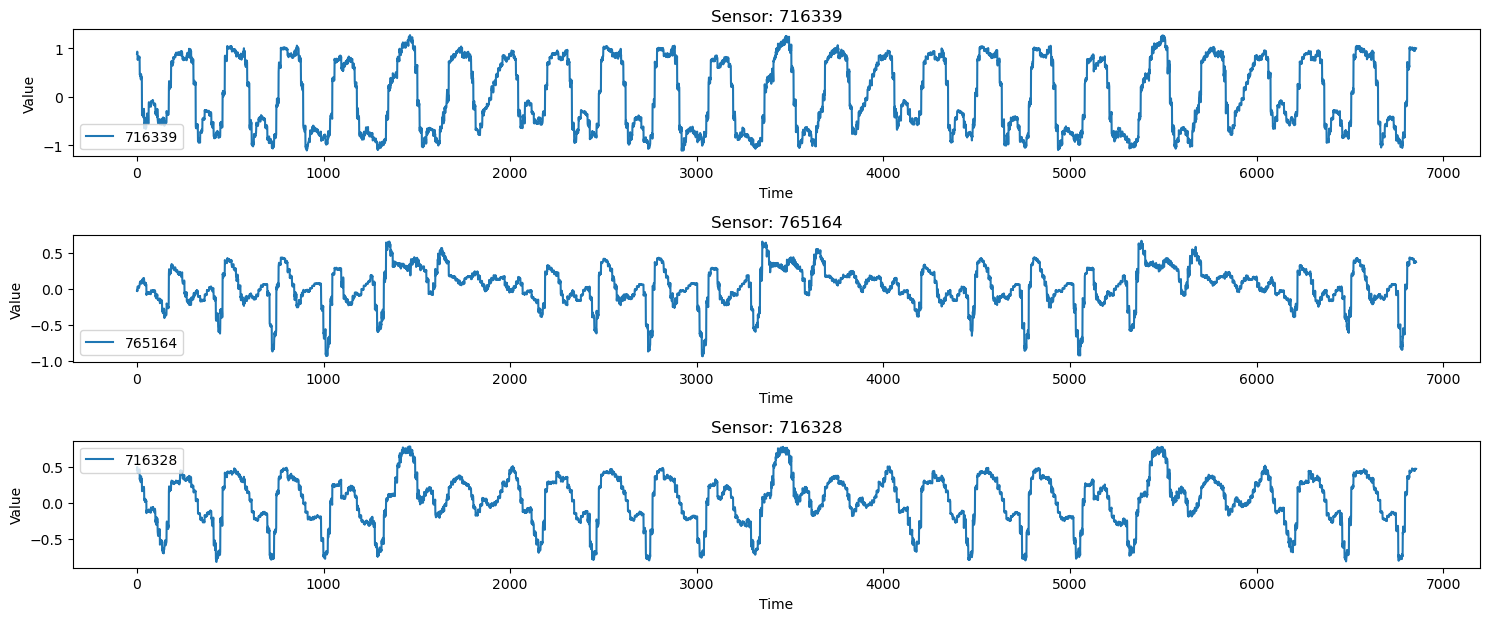

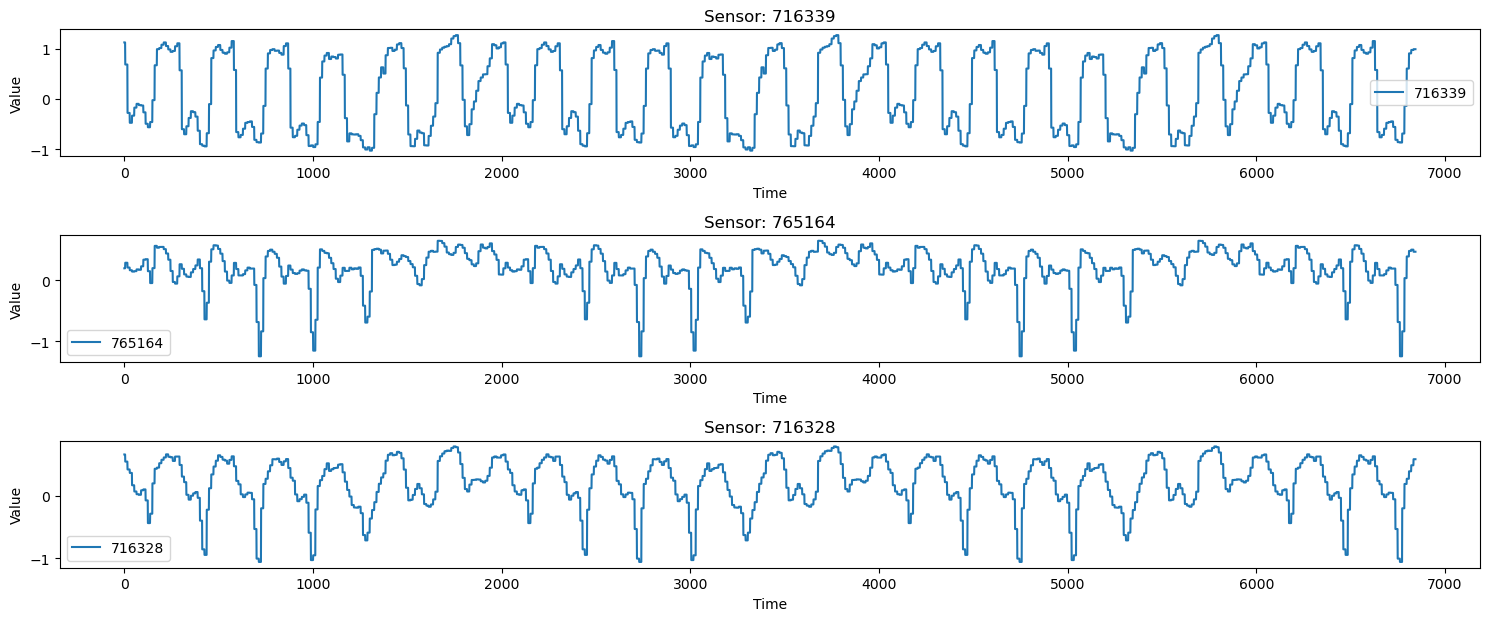

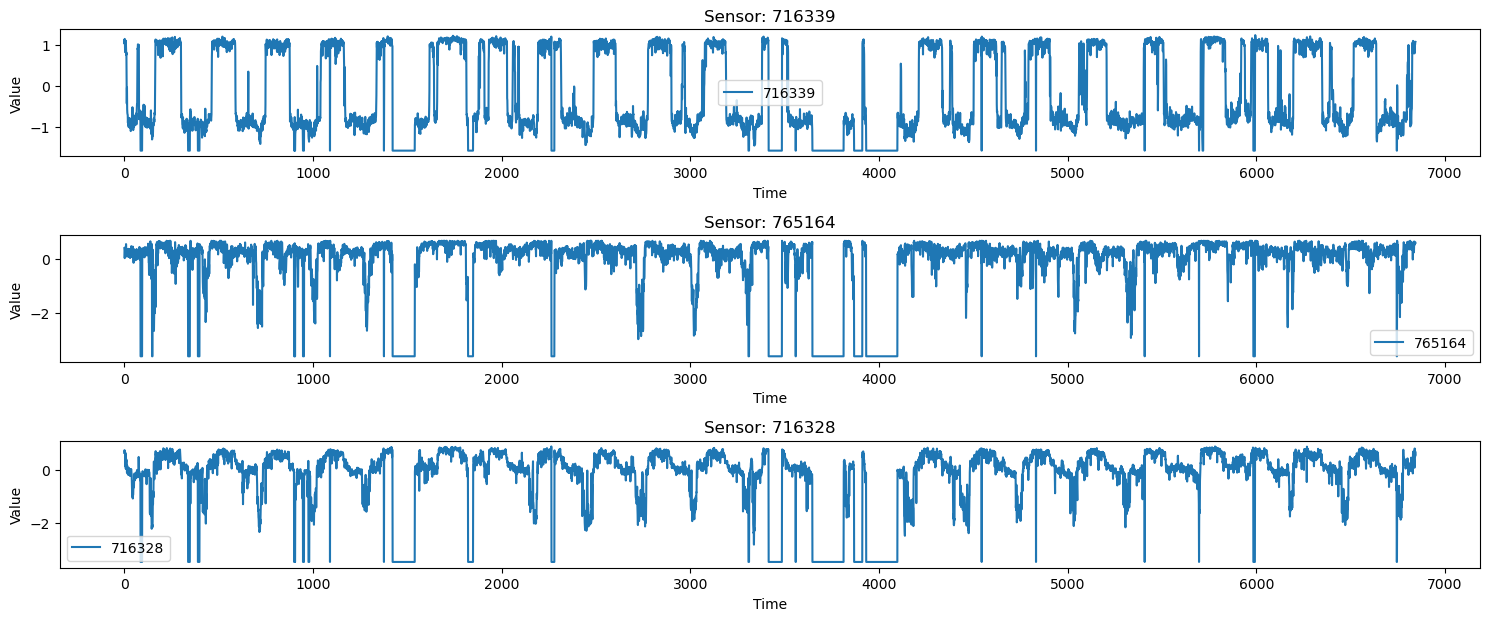

vae_lstm_originals_ (6844, 207)
vae_lstm_recon_all_ (6844, 207)


In [29]:
# plot of reconstructed time series for 3 sensors against the original ones of the same sensors (test set)
specific_sensors = ["716339", "765164", "716328"]

#CVAE
x_recon_all_ = pd.DataFrame(x_test_full_recon.numpy(), columns=df.columns)
cvaerecon_time_series = plot_random_sensors(x_recon_all_, sens=specific_sensors)

#CVAE_LSTM
vae_lstm_recon_all_ = pd.DataFrame(vae_lstm_recon_all.numpy(), columns=df.columns) 
recon_time_series = plot_random_sensors(vae_lstm_recon_all_, sens=specific_sensors)

#ORIGINAL CLEANED
vae_lstm_originals_ = pd.DataFrame(vae_lstm_originals.numpy(), columns=df.columns) 
orig_time_series = plot_random_sensors(vae_lstm_originals_, sens=specific_sensors)

print("vae_lstm_originals_", vae_lstm_originals_.shape)
print("vae_lstm_recon_all_", vae_lstm_recon_all_.shape)

The CVAE‐only and CVAE_LSTM reconstructions appear almost indistinguishable, both effectively suppress noise and recover the global waveform. However, a closer look reveals that the LSTM stage sharpens abrupt transitions potentially producing marginally lower MSE on the test set. These subtle gains could translate into more precise anomaly detection.

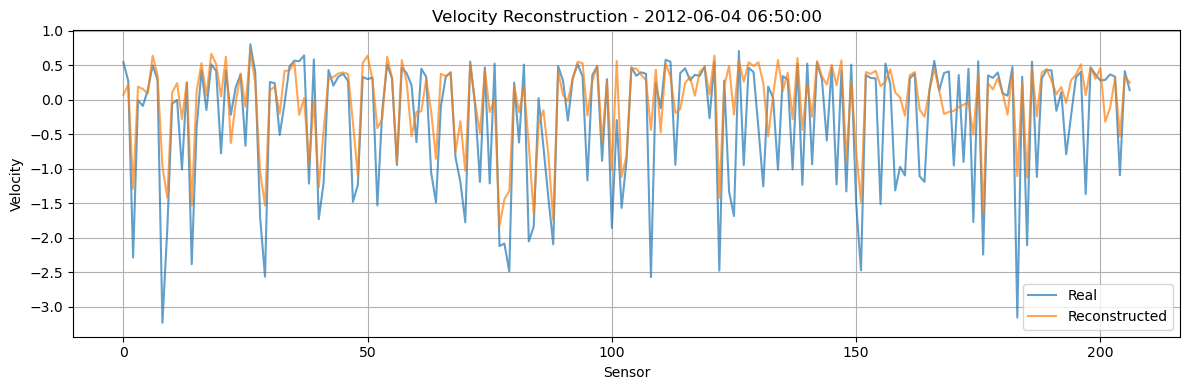

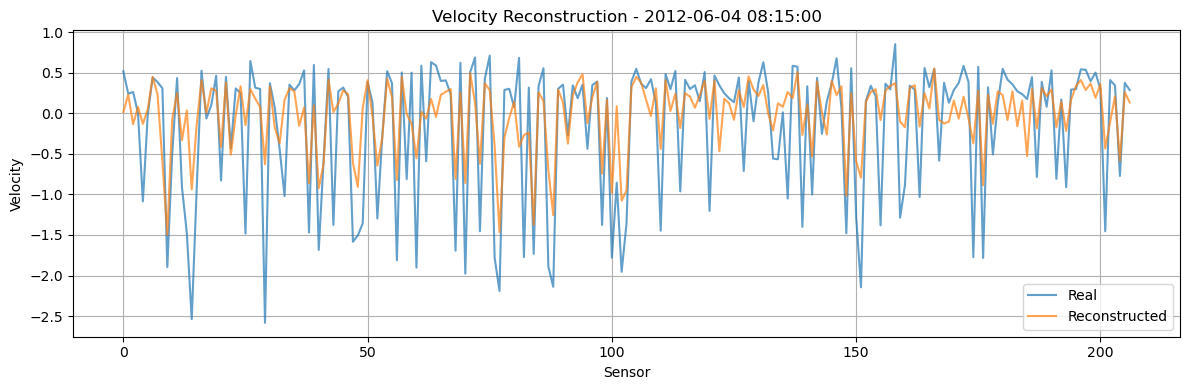

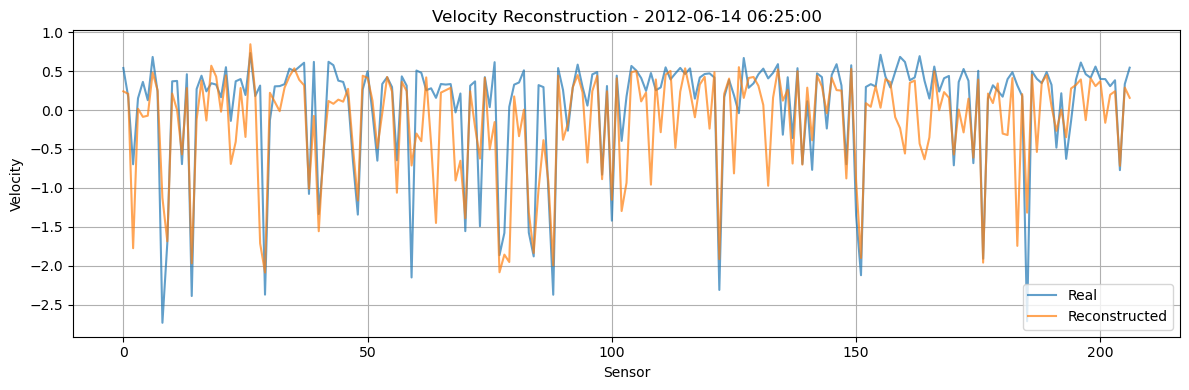

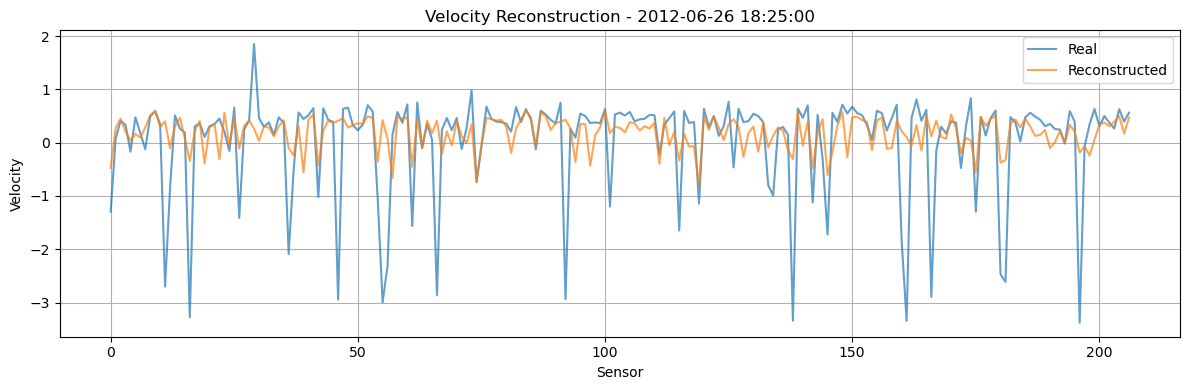

In [30]:
# Plot original vs reconstructed velocities for the selected sample

test_timestamp = df.index[-len(x_test_original):]

# Select a sample index to visualize
sample_indices = [25, 42, 2900, 6500]

for idx in sample_indices:
    timestamp_str = test_timestamp[idx]
    plt.figure(figsize=(12, 4))
    plt.plot(vae_lstm_originals[idx], label="Real", alpha=0.7)
    plt.plot(vae_lstm_recon_all[idx], label="Reconstructed", alpha=0.7)
    plt.title(f"Velocity Reconstruction - {timestamp_str}")
    plt.xlabel("Sensor")
    plt.ylabel("Velocity")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

Across all four snapshots, the CVAE+LSTM reconstruction (orange) closely tracks the main features of the true velocity profile (blue), including the broad up-and-down trends. However, the reconstructed signals consistently under-shoot the most extreme peaks and troughs, yielding a smoother, slightly attenuated version of the sharp dips and spikes in the real data. This behavior reflects the model’s tendency to balance noise reduction with fidelity, capturing the overall structure while moderating outlying values.

In [31]:
# Compute MSE for each sample and sensor (shape: [num_samples, num_sensors])
mse_matrix_lstm = (vae_lstm_originals_ - vae_lstm_recon_all_) ** 2 
print(mse_matrix_lstm.shape)
mse_matrix_lstm = torch.tensor(mse_matrix_lstm.values, dtype=torch.float32)

# Option 2: Use percentile threshold (e.g., 99.5th percentile)
thresholds_lstm = torch.quantile(mse_matrix_lstm, 0.995, dim=0)

# Detect anomalies: boolean matrix where True means anomaly for that sensor in that sample
anomalies_lstm = mse_matrix_lstm > thresholds_lstm

# Count how many sensors are anomalous in each sample
anomalous_counts_lstm = anomalies_lstm.sum(dim=1) 

print("Start of test set:", df.index[-len(x_test)])
print("End of test set:", df.index[-1])
test_timestamps = df.index[-len(x_test):]

(6844, 207)
Start of test set: 2012-06-04 04:45:00
End of test set: 2012-06-27 23:55:00


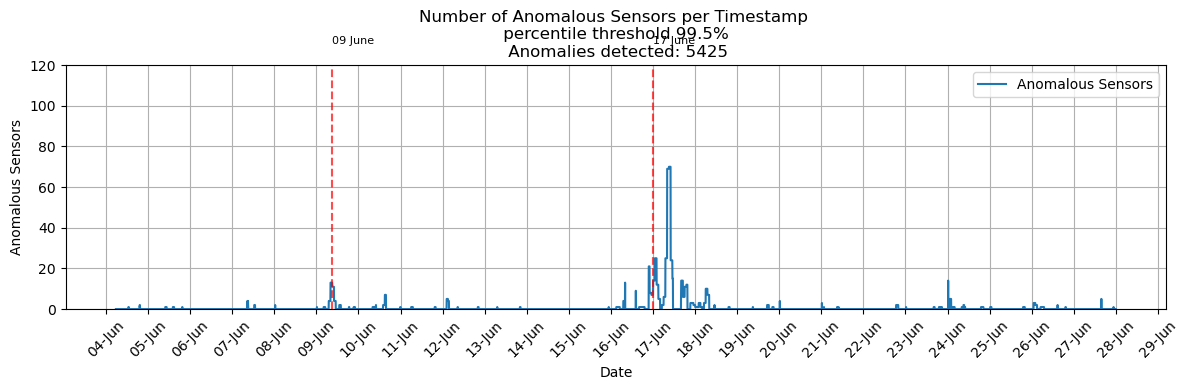

In [32]:
fig, ax = plt.subplots(figsize=(12, 4))

# Plot number of anomalous sensors over time (timestamps)
ax.plot(test_timestamps[11:], anomalous_counts_lstm, label='Anomalous Sensors')

# Format X axis to show dates nicely
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

# Define some important event dates to mark on the plot
event_dates = {
    '17 June': pd.to_datetime('2012-06-17 00:00:00'),
    '09 June': pd.to_datetime('2012-06-09 09:10:00'),
    #'Unexplained Anomaly': pd.to_datetime('2012-06-07 07:35:00')
}

for label, date in event_dates.items():
    ax.axvline(date, color='red', linestyle='--', alpha=0.7)
    ax.text(date, max(anomalous_counts), label,
            rotation=0, verticalalignment='center', fontsize=8)

plt.title(f"Number of Anomalous Sensors per Timestamp \n percentile threshold {percentile*100}% \n Anomalies detected: {anomalies_lstm.sum().sum()}")
plt.xlabel("Date")
plt.ylabel("Anomalous Sensors")
ax.set_ylim(0,120)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


The plot of anomaly counts per timestamp shows a modest bump around June 9, whereas the major outbreak occurs on June 17, with dozens flagged at once. The smaller bump on June 9 likely means that fewer sensors stayed at zero long enough to be flagged, or that our chosen threshold and window size filter out shorter zero‐value periods.

## Conclusions

The variational autoencoder steadily converged to a reconstruction loss of about 0.282 after 50 epochs, identifying pronounced anomaly clusters on June 16–17, 2012 over the June 4–27 test period. Meanwhile, the LSTM predictor converged quickly, achieving a near-zero test loss, which suggests it captured the temporal dynamics of the latent embeddings very effectively, albeit warranting further checks for potential overfitting.

Even if the two strategies (CVAE-only and CVAE_LSTM) seemed promising, with the data we have available and the current models implementation at this moment the simplest CVAE shows to be the best model. By collecting additional data and tweaking model hyperparameters, results could improve in future work.

Overall, this notebook successfully detected major system-wide anomalies; however, we were not able to identify the smaller-scale traffic irregularities that were our primary goal. Addressing those subtler anomalies will be the focus of future work.

## More Visualizations

In this section we plot anomalies counts and the original vs reconstructed time series from CVAE and CVAE_LSTM models over the test dataset.

All zeros rows have been removed from the original test dataset and replaced with reconstructions in order to preserve their timestamps. The purpose of this reconstruction is to observe the models behavior and anomaly detection capabilities without interference from irrelevant system-fault artifacts.

In the counts plots, the vertical dotted lines mark the dates where we have a lot of all-zeros rows in the original dataset , while in the time series they highlight incidents happened on sensors premises. 

To plot the time series 8 sensors placed on the RT 101 us highway (Ventura Freeway) have been chosen. These sensors are located in the same area and are expected to have similar traffic patterns.

In [55]:
# MSE as a score function to spot anomalies, mse per sensor and over window of lenght window_size

import torch.nn.functional as F
import math

class AnomalyDetector:
    """
    A class to detect anomalies in time series data using a score function based on MSE.
    It computes per-sensor MSE between reconstructed and original data, and a rolling mean over a window.
    It plots anomalies counts (anomalous_sensors_count) and time series of original-reconstructed data (series_Wbiggest_anomaly, series_Wmost_anomalies).
    """
    # initialization of the anomaly detector
    def __init__(self, x_recon, x_orig, window_size=12, percentile=99.5, sensors = None, num_sensors=5):
        self.window_size = window_size
        self.percentile = percentile
        self.x_recon = x_recon #pandas DataFrame (comes with and index)
        self.x_orig = x_orig #pandas DataFrame
        self.sensors = sensors # list of sensor IDs to consider, if specific sensors are needed 
        self.num_sensors = num_sensors

    # find accidents on sensor premises
    def accident_localization (self, locations, accidents, sensor_id, d_km= 1.0):
        """
        Given a sensor ID, this function finds the closest accident to that sensor
        and returns its details.
        """
        # Get the location of the sensor
        sensor_location = locations[locations['sensor_id'] == sensor_id]
        
        if sensor_location.empty:
            print(f"Sensor {sensor_id} not found in the locations data.")
            return None  # Sensor not found
        
        sensor_lat = sensor_location['latitude'].values[0]
        sensor_lon = sensor_location['longitude'].values[0]

        # km conversion to degrees
        R = 6371.0  # Radius of the Earth in kilometers
        delta_lat = (d_km / R) * (180 / math.pi)
        delta_lon = delta_lat / math.cos(math.radians(sensor_lat))
        
        # coordinates of the bounding box around the sensor
        north = (sensor_lat + delta_lat, sensor_lon)
        south = (sensor_lat - delta_lat, sensor_lon)
        east  = (sensor_lat, sensor_lon + delta_lon)
        west  = (sensor_lat, sensor_lon - delta_lon)

        # find accidents within the bounding box
        nearest_accidents = accidents[
            (accidents['latitude'] >= south[0]) & (accidents['latitude'] <= north[0]) &
            (accidents['longitude'] >= west[1]) & (accidents['longitude'] <= east[1])
        ].copy()
    
        return nearest_accidents
    
    # Compute MSE and rolling mean MSE, and thresholds for anomaly detection
    def score_function(self):
        """
        Compute the per-sensor MSE between reconstructed and original data, and a rolling mean over a window.
        Returns:
            mse_matrix: DataFrame of raw MSE values (samples x sensors)
            mse_windows: DataFrame of rolling mean MSE (windowed)
            thresholds: Array of per-sensor thresholds (percentile over all MSEs)
            thresholds_windows: Array of per-sensor thresholds (percentile over windowed MSEs)
        """
        # Ensure x_recon and x_orig have the same number of samples
        x_recon = self.x_recon
        x_orig = self.x_orig
        # dif = x_recon.shape[0] - x_orig.shape[0]
        # if dif > 0:
        #     x_recon = x_recon[:x_orig.shape[0]] 
        # elif dif < 0:
        #     x_orig = x_orig[-x_recon.shape[0]:]
            
        # Compute per-sample, per-sensor MSE
        mse_matrix = (x_recon - x_orig) ** 2  
        mse_matrix = pd.DataFrame(mse_matrix, index=x_orig.index, columns=x_orig.columns)
        

        # Compute rolling mean MSE over the specified window size 
        mse_windows = mse_matrix.rolling(window=self.window_size, min_periods=self.window_size).mean() 

        # Compute anomaly thresholds as the given percentile for each sensor (over a window)
        #thresholds = np.percentile(mse_matrix.values, percentile, axis=0) 
        thresholds_windows = np.nanpercentile(mse_windows.values, self.percentile, axis=0) 
        thresholds_windows = pd.Series(thresholds_windows, index=mse_windows.columns)

        return mse_windows , thresholds_windows #to return mse_matrix and thresholds is redundant
    
    # Detect anomalies: boolean matrix where True means anomaly for that sensor in that sample
    def anomalies_per_timestamp(self):
        """
        Detect anomalies in each sample based on the MSE thresholds.
        Returns a boolean matrix where True indicates an anomaly for that sensor in that sample.
        """
        mse_windows, thresholds_windows = self.score_function()
        anomalies = mse_windows > thresholds_windows 
        print(f"Anomalies detected: {anomalies.sum().sum()}")  # Total number of anomalies detected
        return anomalies.sum(axis=1) 

    # anomalies counts per timestamp
    def anomalous_sensors_count(self, num_samples=10):
        """
        Print the top samples with the most anomalies and plot the number of anomalous sensors per timestamp.
        """
        anomalies = self.anomalies_per_timestamp()
        # Convert to tensor for torch.topk
        anomalies = torch.tensor(anomalies.values)
        top_indices = torch.topk(anomalies, num_samples).indices
        
        print(f"Top {num_samples} samples with most anomalies:")
        for idx in top_indices:
            # Get the timestamp for the sample
            mse_windows, _ = self.score_function()
            ts = mse_windows.index[idx.item()]
            count = anomalies[idx].item()  # Get number of anomalous sensors in that sample
            print(f"Index: {idx.item()} → Date: {ts} → Anomalous Sensors: {count}")

        ax = plt.subplots(figsize=(12, 4))

        # Plot number of anomalous sensors over time (timestamps) on test dataset
        ax.plot(mse_windows.index, anomalies.numpy(), label='Anomalous Sensors')

        # Format X axis to show dates nicely
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

        # Define some important event dates to mark on the plot
        event_dates = {
            '': pd.to_datetime('2012-06-17 00:00:00'),
            '.': pd.to_datetime('2012-06-09 09:10:00'),
            #'Unexplained Anomaly': pd.to_datetime('2012-06-07 07:35:00')
        }

        for label, date in event_dates.items():
            ax.axvline(date, color='red', linestyle='--', alpha=0.7)
            ax.text(date, max(anomalous_counts), label,
                    rotation=0, verticalalignment='center', fontsize=8)

        plt.title(f"Number of Anomalous Sensors per Timestamp \n percentile threshold: {self.percentile}% \n detected anomalies: {anomalies.sum().sum()}")
        plt.xlabel("Date")
        plt.ylabel("Anomalous Sensors")
        ax.set_ylim(0,120)
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.legend()
        plt.show()

    # time series reconstruction and anomaly detection
    def series(self, locations=None, accidents=None, d_km= 1.0):
        """
        Plot series with original, reconstructed data, anomalous windows and accidents on premises.
        Options: series of sensors with biggest MSE peaks or with most anomalies (option to comment or decomment); series of specific sensors.
        """
        num_sensors = self.num_sensors

        mse_windows, thresholds_windows = self.score_function()
        anomalies = mse_windows > thresholds_windows

        if self.sensors is not None:
            top_sensors = self.sensors
        elif self.sensors is None:
            # Trova per ogni sensore il valore massimo di rolling MSE e il relativo indice
            max_mse = mse_windows.max()
            # Prendi i 10 sensori con il massimo valore assoluto di rolling MSE
            top_sensors = max_mse.sort_values(ascending=False).head(num_sensors).index

            # # OPPURE: Scegli i sensori con più anomalie
            # max_anomalies_count = anomalies.sum(axis=0)
            # top_sensors = max_anomalies_count.sort_values(ascending=False).head(num_sensors).index


        fig = plt.figure(figsize=(15, 20))
        if self.sensors is not None:
            fig.suptitle(f"Series of sensors: {top_sensors} \n ({self.window_size}-step windows) \n percentile threshold: {self.percentile}%")
        elif self.sensors is None:
            fig.suptitle(f"Top {num_sensors} series with most {self.window_size}-step Anomaly Windows \n percentile threshold: {self.percentile}%")
            # OPPURE: fig.suptitle(f"Top {num_sensors} series with biggest MSE peaks ({self.window_size}-step windows) \n percentile threshold: {self.percentile}%")
        
        for row, sensor in enumerate(top_sensors, start=1):
            # for this sensor, identify the anomalous timestamps
            sensor_anoms = anomalies[sensor]
            anomalous_times = mse_windows.index[sensor_anoms.values]

            # extract original and reconstructed series
            series = self.x_orig[sensor]
            recon  = self.x_recon[sensor]

            ax = plt.subplot(num_sensors, 1, row)
            # Format X axis to show dates nicely
            ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
            ax.plot(series.index, series, label='Original',   alpha=0.7)
            ax.plot(series.index, recon,  label='Reconstructed', alpha=0.7)
            # ax2 = ax.twinx()
            # ax2.plot(series.index, mse_windows[sensor], label='Rolling MSE', color='black', alpha=0.4)
            # ax2.set_ylabel("MSE")
            ax.set_title(f"Sensor {sensor}")
            ax.set_xlabel("Time")
            ax.set_ylabel("Value")
            for label in ax.get_xticklabels():
                label.set_rotation(45)
            # for label in ax2.get_xticklabels():
            #     label.set_rotation(45)

            # Highlight each anomalous window
            first_span = True
            for win_time in anomalous_times:
                # find the integer position of the timestamp win_time
                pos = series.index.get_indexer([win_time])[0]
                start = max(0, pos - self.window_size + 1)
                end   = pos + 1
                if end > start:
                    label = 'Anomalous window' if first_span else None
                    ax.axvspan(series.index[start], series.index[end-1],
                            color='red', alpha=0.2, label=label)
                    first_span = False

            # draw a dotted vertical line for each nearby accident
            if locations is not None and accidents is not None:
                nearby_accidents = self.accident_localization(locations, accidents, sensor, d_km)
                if nearby_accidents is not None and not nearby_accidents.empty:
                    first_accident = True
                    for _, acc in nearby_accidents.iterrows():
                        # Assure the timestamp is in datetime format
                        if 'timestamp' in acc:
                            acc_time = pd.to_datetime(acc['timestamp'])
                        else:
                            acc_time = pd.to_datetime(acc['collision_date'] + ' ' + acc['collision_time'])
                        label = 'Accident' if first_accident else '_nolegend_'
                        ax.axvline(acc_time, color='blue', linestyle=':', alpha=0.7, linewidth=1.5, label=label)
                        first_accident = False

            ax.legend(loc='upper right')

            #plt.xticks(rotation=45)

        plt.tight_layout()
        plt.subplots_adjust(top=0.89) 
        plt.show()

        return top_sensors

In [41]:
# Prepare indexes and columns for DataFrames
df_time_train, df_time_test = train_test_split(df_time, test_size=0.2, shuffle=False)
index = df_time_test.index  # Index for train set
columns = df.columns

vae_lstm_recon_all_.index = index[11:] # by structure the LSTM first compute the 12th embedding using the first 11, so we need to shift the index by 11
vae_lstm_originals_.index = index[11:]

# Initialize the anomaly detector with the reconstructed and original data
x_test_full_recon_pd = pd.DataFrame(x_test_full_recon.numpy(), index=df_time_test.index, columns=columns)
x_orig_all_pd = pd.DataFrame(x_orig_all.numpy(), index=df_time_test.index, columns=columns)

# detector_cvae = AnomalyDetector(x_test_full_recon_pd, x_orig_all_pd, window_size=12, percentile=95)
# detector_all = AnomalyDetector(vae_lstm_recon_all_, vae_lstm_originals_, window_size=12, percentile=95)

# # use AnomalyDetector methods
# # ...

# # Clean up
# del detector_cvae, detector_all

In [42]:
# Replace test dataset all-zeros rows with the reconstructed ones
mask_zero_rows_test = (x_test_original.sum(axis=1) == 0)

# cvae test dataset cleaned
x_orig_all_cleaned = x_orig_all_pd.copy()
x_orig_all_cleaned.loc[mask_zero_rows_test] = x_test_full_recon_pd.loc[mask_zero_rows_test]

# all (=cvae+lstm) test dataset cleaned
vae_lstm_originals_cleaned = vae_lstm_originals_.copy()
vae_lstm_originals_cleaned.loc[mask_zero_rows_test[11:]] = vae_lstm_recon_all_.loc[mask_zero_rows_test[11:]]

# (Opzionale) Verifica dimensioni e un paio di righe
print("vae cleaned test dataset shape:", x_orig_all_cleaned.shape)
print("vae_lstm cleaned test dataset shape:", vae_lstm_originals_cleaned.shape)

vae cleaned test dataset shape: (6855, 207)
vae_lstm cleaned test dataset shape: (6844, 207)


In [ ]:
# # Try anomaly detection on cleaned datasets

# detector_cvae_cleaned = AnomalyDetector(x_test_full_recon_pd, x_orig_all_cleaned, window_size=24, percentile=90)
# detector_all_cleaned = AnomalyDetector(vae_lstm_recon_all_, vae_lstm_originals_cleaned, window_size=24, percentile=90)

# # Use AnomalyDetector methods on cleaned datasets
# # ...

# del detector_cvae_cleaned, detector_all_cleaned

In [ ]:
import folium
from folium.plugins import MarkerCluster
from IPython.display import display

# Sensors and accidents localization on map

# Upload data
locations = pd.read_csv('data/sensor_graph/graph_sensor_locations.csv')
locations['sensor_id'] = locations['sensor_id'].astype(str) # to help find the sensor_id in the accident_localization method
accidents = pd.read_csv('AccidentsFinalDataset.csv')

# # Find sensors in location
# locations['sensor_id'] = locations['sensor_id'].astype(str)
# top_sensors = [str(s) for s in top_sensors_all_cleaned]
# anomalous_locations = locations[locations['sensor_id'].isin(top_sensors)]

# # Build the map centered around the average location of sensors and the MarkerCluster
center = [locations['latitude'].mean(), locations['longitude'].mean()]
m = folium.Map(location=center, zoom_start=10)
#cluster = MarkerCluster(name='Sensori e Incidenti').add_to(m)

# Add sensor locations in red to the map
#for _, row in anomalous_locations.iterrows():
for _, row in locations.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=8,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        popup=f"Sensor ID: {row['sensor_id']}"
    ).add_to(m)

# Add accident locations in blue to the map
for _, row in accidents.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.5,
        popup=f"Accident ID: {row.get('primary_road')}"
    ).add_to(m)

#folium.LayerControl().add_to(m)

# Inline display of the map and optional save to HTML file
display(m)
#m.save("sensori_e_incidenti.html")


In [44]:
# Accidents dataset processing 

# Only keep relevant rows: between 4 and 29 June 2012, with valid collision_time
accidents['collision_date'] = pd.to_datetime(accidents['collision_date'], errors='coerce')
accidents = accidents[accidents['collision_time'].notnull()]  # Rimuovi righe con date non valide
accidents = accidents[(accidents['collision_date'] >= '2012-06-04') & (accidents['collision_date'] <= '2012-06-29')]
# Convert 'collision_date' and 'collision_time' to string and ensure it has 4 digits (HHMM)
accidents['collision_time'] = accidents['collision_time'].str.zfill(4)  # Be sure time is in HHMM format
accidents['collision_date'] = accidents['collision_date'].dt.strftime('%Y-%m-%d')  # Convert to string format


accidents['timestamp'] = accidents['collision_date'].astype(str) + ' ' + accidents['collision_time'].astype(str)
print (accidents['timestamp'].head(2))  # Check the new timestamp column
accidents.index = accidents['timestamp']  # Set the timestamp as index
# we are interested in columns: 'latitude', 'longitude', 'timestamp'.

1513    2012-06-08 22:40:00
1800    2012-06-15 13:00:00
Name: timestamp, dtype: object


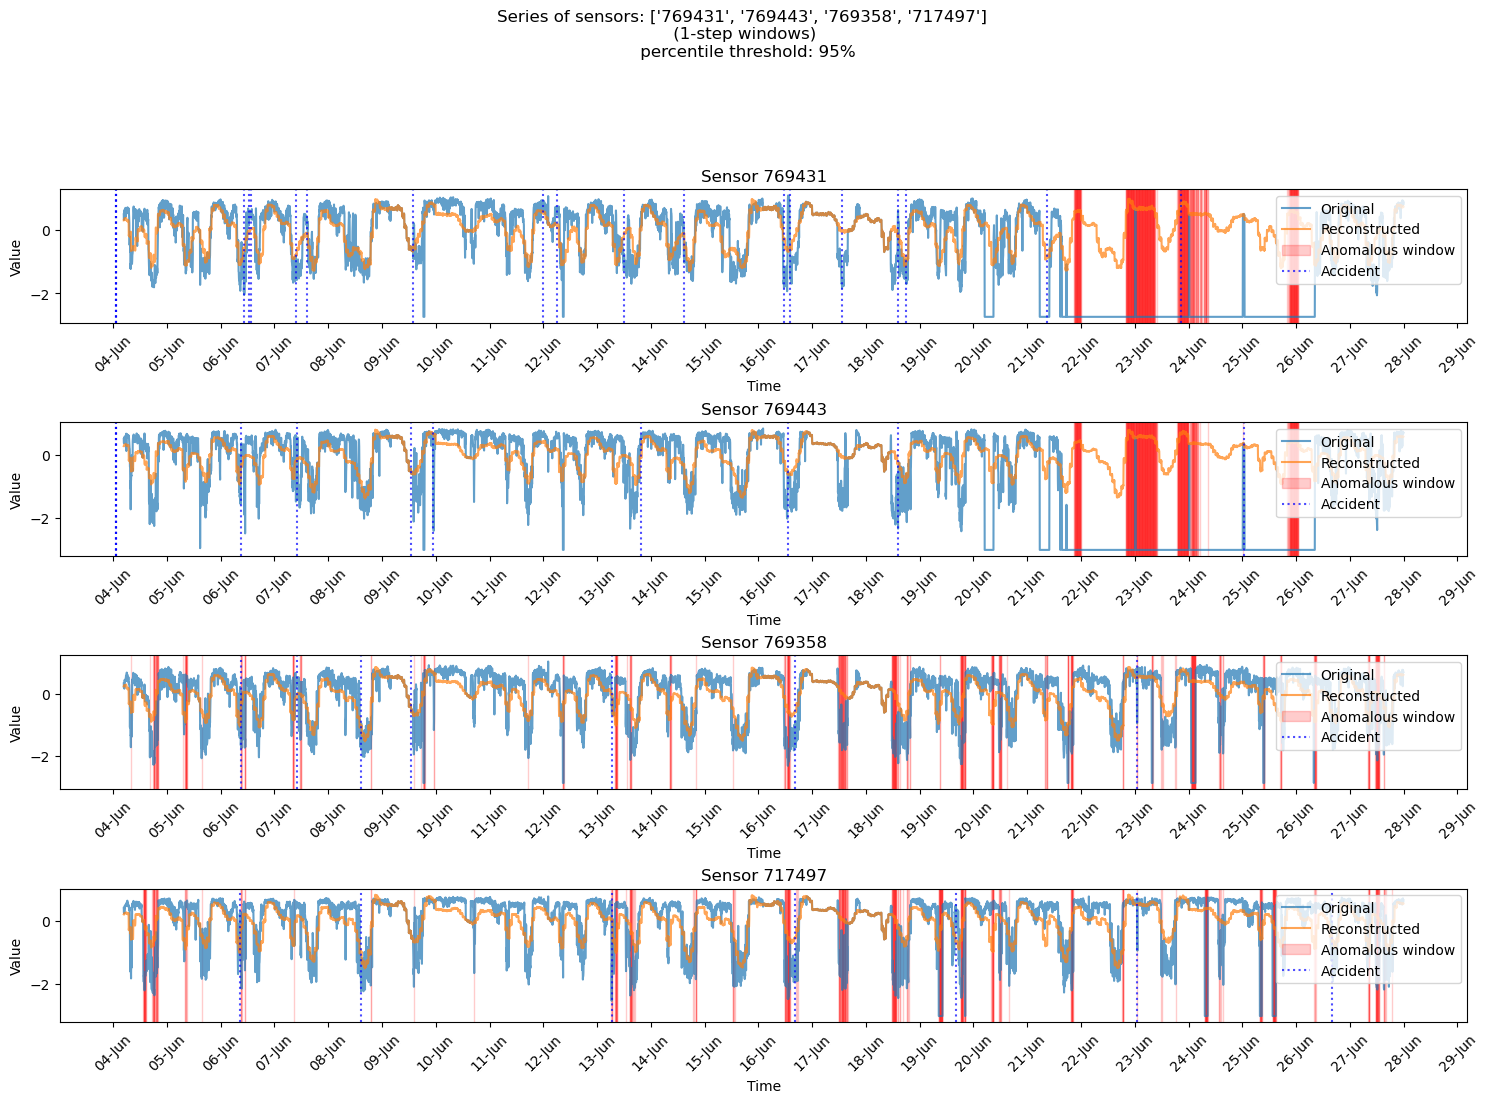

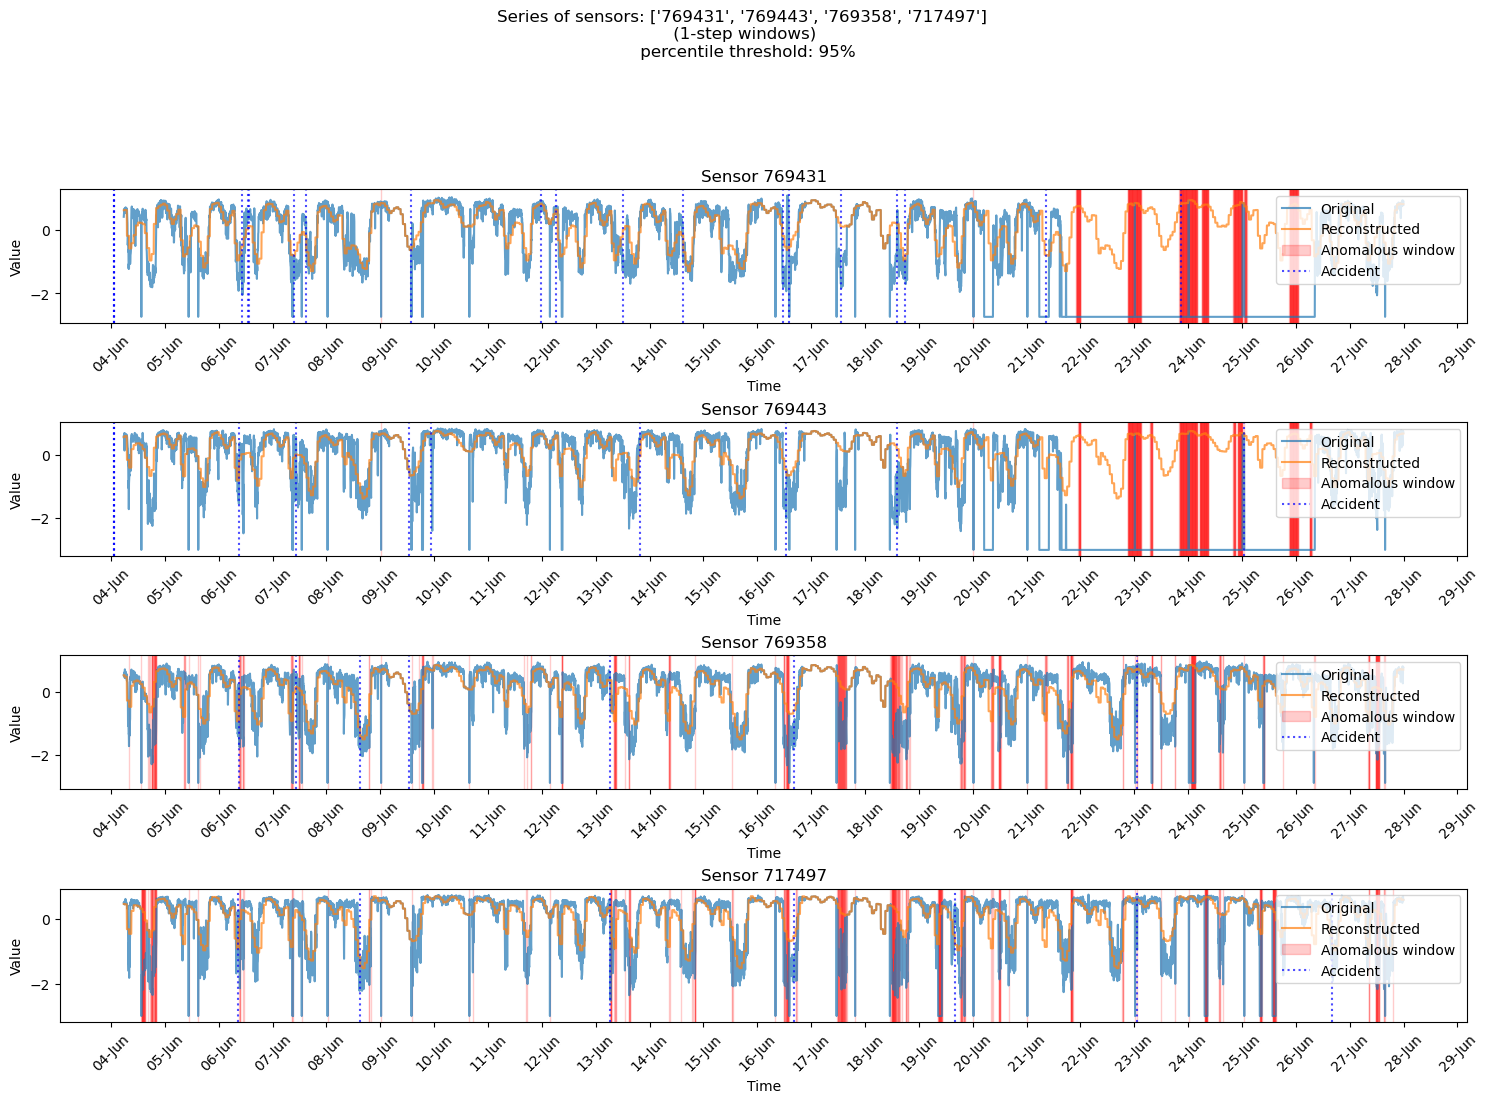

In [64]:
# Select sensors on a strecth of RT 101 us highway in Los Angeles (arbitrary choice), direction west.
detector_sensors_RT101 = [
    "769431", "769443", "717498", "769358", "717497",
    "769346", "769467", "717492"]

detector_sensors = ["769431", "769443", "769358", "717497"] # fewer sensors for better visualization (in sequential locations on RT 101)

# Intialization of the anomaly detectors with cleaned datasets
detector_cvae_cleaned = AnomalyDetector(x_test_full_recon_pd, x_orig_all_cleaned, window_size=1, percentile=95, sensors=detector_sensors, num_sensors=8)
detector_all_cleaned = AnomalyDetector(vae_lstm_recon_all_, vae_lstm_originals_cleaned, window_size=1, percentile=95, sensors=detector_sensors, num_sensors=8)

# Plot series of requested sensors
top_sensors_cvae_cleaned = detector_cvae_cleaned.series(locations=locations, accidents=accidents) 
top_sensors_all_cleaned = detector_all_cleaned.series(locations=locations, accidents=accidents)

# clean
del detector_cvae_cleaned, detector_all_cleaned

Parameters of these time series are : window_size = 1 (sensor anomaly flagged over the MSE of a single timestamp) and threshold = 95% . Of course results can vary depending on these parameters.

What to observe: \
LSTM seems not to add significant value to the CVAE model in terms of anomaly detection, as the CVAE-only model already captures the main traffic patterns and anomalies effectively.\
for the above series sensor went off for some days, the model is clearly spotting the system anomaly, but our quest is originally driven by the need to identify and respond to TRAFFIC anomalies. 
Sometimes the model/s seem/s to signal an anomaly when an accident happend in the surrounding area, but they/it are/is not so precise; many anomalies are raised when we have apparently no reason to justify them and viceversa. 

To conclude, we are perfectly aware that traffic anomalies are likely related to more factors beyond simple car accidents, such as weather conditions, road works, etc. For a better investigation of the model(s) potential, collecting more data would be essential both for model/s training and assessment. For instance, having anomalies labels would help in fine-tuning hyperparameters and score function toward a more precise early alert system of traffic flows.